In [1]:
cd ..

/media/hjp/FAAC278CAC27430D/HJP/KUAICV/Hand/AbsoluteTrack


In [2]:
pwd

'/media/hjp/FAAC278CAC27430D/HJP/KUAICV/Hand/AbsoluteTrack'

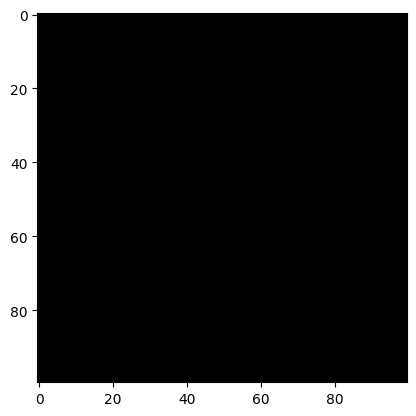

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
# matplotlib
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interactive, IntSlider, Output
from IPython.display import clear_output, display

# %matplotlib widget 

import mediapipe as mp



img = np.zeros((100, 100), dtype=np.uint8)
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.show()

In [4]:
# LICENSE file in the root directory of this source tree.

import os

import av
import fnmatch
import pickle
import numpy as np
import torch

import lib.data_utils.fs as fs

from functools import partial

# from lib.tracker.perspective_crop import landmarks_from_hand_pose


#from multiprocessing import Pool
#from typing import Optional, Tuple

from lib.models.model_loader import load_pretrained_model

#from lib.tracker.tracker import HandTracker, HandTrackerOpts, InputFrame, ViewData
from lib.tracker.video_pose_data import SyncedImagePoseStream

from typing import Dict, NamedTuple

#from lib.common.hand import NUM_HANDS, NUM_LANDMARKS_PER_HAND
NUM_HANDS = 2
NUM_LANDMARKS_PER_HAND = 21
NUM_FINGERTIPS_PER_HAND = 5
NUM_JOINTS_PER_HAND = 22
LEFT_HAND_INDEX = 0
RIGHT_HAND_INDEX = 1

NUM_DIGITS: int = 5
NUM_JOINT_FRAMES: int = 1 + 1 + 3 * 5  # root + wrist + finger frames * 5
DOF_PER_FINGER: int = 4

# import from lib.common.affine.py

In [5]:
import numpy as np
from scipy.spatial.transform import Rotation


def transform3(m, v):
    return transform_vec3(m, v) + m[..., :3, 3]


def transform_vec3(m, v):
    if m.ndim == 2:
        return (v.reshape(-1, 3) @ m[:3, :3].T).reshape(v.shape)
    else:
        return (m[..., :3, :3] @ v[..., None]).squeeze(-1)


def normalized(v: np.ndarray, axis: int = -1, eps: float = 5.43e-20) -> np.ndarray:
    d = np.maximum(eps, (v * v).sum(axis=axis, keepdims=True) ** 0.5)
    return v / d


def skew_matrix(v: np.ndarray) -> np.ndarray:
    res = np.array(
        [[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]], dtype=v.dtype
    )
    return res


def from_two_vectors(a_orig: np.ndarray, b_orig: np.ndarray) -> np.ndarray:
    a = normalized(a_orig)
    b = normalized(b_orig)
    v = np.cross(a, b)
    s = np.linalg.norm(v)
    c = np.dot(a, b)
    v_mat = skew_matrix(v)

    rot = np.eye(3, 3) + v_mat + np.matmul(v_mat, v_mat) * (1 - c) / (max(s * s, 1e-15))

    return rot


def make_look_at_matrix(
    orig_world_to_eye: np.ndarray,
    center: np.ndarray,
    camera_angle: float = 0,
) -> np.ndarray:
    """
    args:
        orig_world_to_eye:  world to eye transform
            inverse of camera.camera_to_world_xf
        center:  np.array. (3,)
            3D world coordinate of center of the object of interest
        camera_angle: the angle of the camera
            camera_angle: how the camera is oriented physically so that we can rotate the object of
            interest to the 'upright' direction
    """
    center_local = transform3(orig_world_to_eye, center)
    z_dir_local = center_local / np.linalg.norm(center_local)
    delta_r_local = from_two_vectors(
        np.array([0, 0, 1], dtype=center.dtype), z_dir_local
    )
    orig_eye_to_world = np.linalg.inv(orig_world_to_eye)

    new_eye_to_world = orig_eye_to_world.copy()
    new_eye_to_world[0:3, 0:3] = orig_eye_to_world[0:3, 0:3] @ delta_r_local

    # Locally rotate the z axis to align with the camera angle
    z_local_rot = Rotation.from_euler("z", camera_angle, degrees=True).as_matrix()
    new_eye_to_world[0:3, 0:3] = new_eye_to_world[0:3, 0:3] @ z_local_rot

    return np.linalg.inv(new_eye_to_world)



# import from lib.common.camera

In [6]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
# All rights reserved.

# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.

import abc
import json
import math
from typing import NamedTuple, Sequence, Tuple, Type

import numpy as np
from typing_extensions import Protocol, runtime_checkable


class CameraProjection(Protocol):
    """
    Defines a projection from a 3D `xyz` direction or point to 2D.
    """

    @classmethod
    @abc.abstractmethod
    def project(cls, v):
        """
        Project a 3d vector in eye space down to 2d.
        """
        ...

    @classmethod
    @abc.abstractmethod
    def unproject(cls, p):
        """
        Unproject a 2d point to a unit-length vector in eye space.

        `project(unproject(p)) == p`
        `unproject(project(v)) == v / |v|`
        """
        ...


@runtime_checkable
class DistortionModel(Protocol):
    @abc.abstractmethod
    def evaluate(self: Sequence[float], p: np.ndarray) -> np.ndarray:
        """
        Arguments
        ---------
        p: ndarray[..., 2]
            Array of 2D points, of arbitrary batch shape.

        Returns
        -------
        q: ndarray[..., 2]
            Distorted points with same shape as input
        """
        ...


class PerspectiveProjection(CameraProjection):
    @staticmethod
    def project(v):
        # map to [x/z, y/z]
        assert v.shape[-1] == 3
        return v[..., :2] / v[..., 2, None]

    @staticmethod
    def unproject(p):
        # map to [u,v,1] and renormalize
        assert p.shape[-1] == 2
        x, y = np.moveaxis(p, -1, 0)
        v = np.stack((x, y, np.ones(shape=x.shape, dtype=x.dtype)), axis=-1)
        v = normalized(v, axis=-1)
        return v


class ArctanProjection(CameraProjection):
    @staticmethod
    def project(p, eps: float = 2.0**-128):
        
        """
        eye space to projected space
        It seems arctan projection is same as equid
        """
        
        
        assert p.shape[-1] == 3
        x, y, z = np.moveaxis(p, -1, 0)
        r = np.sqrt(x * x + y * y)
        s = np.arctan2(r, z) / np.maximum(r, eps)
        return np.stack((x * s, y * s), axis=-1)

    @staticmethod
    def unproject(uv):
        assert uv.shape[-1] == 2
        u, v = np.moveaxis(uv, -1, 0)
        r = np.sqrt(u * u + v * v)
        c = np.cos(r)
        s = np.sinc(r / np.pi)
        return np.stack([u * s, v * s, c], axis=-1)


class NoDistortion(NamedTuple):
    """
    A trivial distortion model that does not distort the incoming rays.
    """

    def evaluate(self, p: np.ndarray) -> np.ndarray:
        return p


class Fisheye62CameraModel(NamedTuple):
    """
    Fisheye62CameraModel model, with 6 radial and 2 tangential coeffs.
    """

    k1: float
    k2: float
    k3: float
    k4: float
    p1: float
    p2: float
    k5: float
    k6: float

    def evaluate(self: Sequence[float], p: np.ndarray) -> np.ndarray:
        k1, k2, k3, k4, p1, p2, k5, k6 = self
        # radial component
        r2 = (p * p).sum(axis=-1, keepdims=True)
        r2 = np.clip(r2, -np.pi**2, np.pi**2)
        r4 = r2 * r2
        r6 = r2 * r4
        r8 = r4 * r4
        r10 = r4 * r6
        r12 = r6 * r6
        radial = 1 + k1 * r2 + k2 * r4 + k3 * r6 + k4 * r8 + k5 * r10 + k6 * r12
        uv = p * radial

        # tangential component
        x, y = uv[..., 0], uv[..., 1]
        x2 = x * x
        y2 = y * y
        xy = x * y
        r2 = x2 + y2
        x += 2 * p2 * xy + p1 * (r2 + 2 * x2)
        y += 2 * p1 * xy + p2 * (r2 + 2 * y2)
        return np.stack((x, y), axis=-1)


# ---------------------------------------------------------------------
# API Conventions and naming
#
# Points have the xyz or uv components in the last axis, and may have
# arbitrary batch shapes. ([...,2] for 2d and [...,3] for 3d).
#
# v
#    3D xyz position in eye space, usually unit-length.
# p
#    projected uv coordinates: `p = project(v)`
# q
#    distorted uv coordinates: `q = distort(p)`
# w
#    window coordinates: `q = q * f + [cx, cy]`
#
# A trailing underscore (e.g. `p_`, `q_`) should be read as "hat", and
# generally indicates an approximation to another value.
# ---------------------------------------------------------------------


class CameraModel(CameraProjection, abc.ABC):
    """
    Parameters
    ----------
    width, height : int
        Size of the sensor window

    f : float or tuple(float, float)
        Focal length

    c : tuple(float, float)
        Optical center in window coordinates

    distort_coeffs
        Forward distortion coefficients (eye -> window).

        If this is an instance of DistortionModel, it will be used as-is
        (even if it's a different polynomial than this camera model
        would normally use.) If it's a simple tuple or array, it will
        used as coefficients for `self.distortion_model`.

    camera_to_world_xf : np.ndarray
        Camera's position and orientation in world space, represented as
        a 3x4 or 4x4 matrix.

        The matrix be a rigid transform (only rotation and translation).

        You can change a camera's camera_to_world_xf after construction by
        assigning to or modifying this matrix.

    Attributes
    ----------
    Most attributes are the same as constructor parameters.

    distortion_model
        Class attribute giving the distortion model for new instances.

    """

    width: int
    height: int

    f: Tuple[float, float]
    c: Tuple[float, float]

    camera_to_world_xf: np.ndarray

    distortion_model: Type[DistortionModel]
    distort: DistortionModel

    def __init__(
        self,
        width,
        height,
        f,
        c,
        distort_coeffs,
        camera_to_world_xf=None,
    ):  # pylint: disable=super-init-not-called (see issue 4790 on pylint github)
        self.width = width
        self.height = height

        # f can be either a scalar or (fx,fy) pair. We only fit scalars,
        # but may load (fx, fy) from a stored file.
        self.f = tuple(np.broadcast_to(f, 2))
        self.c = tuple(c)

        if camera_to_world_xf is None:
            self.camera_to_world_xf = np.eye(4)
        else:
            self.camera_to_world_xf = camera_to_world_xf

        if isinstance(distort_coeffs, DistortionModel):
            self.distort = distort_coeffs
        else:
            self.distort = self.distortion_model(*distort_coeffs)

    def __repr__(self):
        return (
            f"{type(self).__name__}({self.width}x{self.height}, f={self.f} c={self.c}"
        )

    def copy(self, camera_to_world_xf=None):
        """Return a copy of this camera

        Arguments
        ---------
        camera_to_world_xf : 4x4 np.ndarray
            Optional new camera_to_world_xf for the new camera model.
            Default is to copy this camera's camera_to_world_xf.
        """
        return self.crop(0, 0, self.width, self.height, camera_to_world_xf=camera_to_world_xf)

    def world_to_eye(self, v):
        """
        Apply camera camera_to_world_xf to points `v` to get eye coords
        """
        return transform_vec3(self.camera_to_world_xf.T, v - self.camera_to_world_xf[:3, 3])

    def eye_to_world(self, v):
        """
        Apply inverse camera camera_to_world_xf to eye points `v` to get world coords
        """
        return transform3(self.camera_to_world_xf, v)

    def eye_to_window(self, v):
        """Project eye coordinates to 2d window coordinates"""
        p = self.project(v)
        q = self.distort.evaluate(p)
        return q * self.f + self.c

    def window_to_eye(self, w):
        """Unproject 2d window coordinates to unit-length 3D eye coordinates"""
        q = (np.asarray(w) - self.c) / self.f
        # assert isinstance(
        #     self.distort, NoDistortion
        # ), "Only unprojection for NoDistortion camera is supported"
        return self.unproject(q)

    def crop(
        self,
        src_x,
        src_y,
        target_width,
        target_height,
        scale=1,
        camera_to_world_xf=None,
    ):
        """
        Return intrinsics for a crop of the sensor image.

        No scaling is applied; this just returns the model for a sub-
        array of image data. (Or for a larger array, if (x,y)<=0 and
        (width, height) > (self.width, self.height).

        To do both cropping and scaling, use :meth:`subrect`

        Parameters
        ----------
        x, y, width, height
            Location and size in this camera's window coordinates
        """
        return type(self)(
            target_width,
            target_height,
            np.asarray(self.f) * scale,
            (np.array(self.c) - (src_x, src_y) + 0.5) * scale - 0.5,
            self.distort,
            self.camera_to_world_xf if camera_to_world_xf is None else camera_to_world_xf,
        )


# Camera models
# =============


class PinholePlaneCameraModel(PerspectiveProjection, CameraModel):
    distortion_model = NoDistortion

    def uv_to_window_matrix(self):
        """Return the 3x3 intrinsics matrix"""
        return np.array(
            [[self.f[0], 0, self.c[0]], [0, self.f[1], self.c[1]], [0, 0, 1]]
        )


class Fisheye62CameraModel(ArctanProjection, CameraModel):
    distortion_model = Fisheye62CameraModel
    
    @staticmethod
    def unproject(uv):
        """
        Unproject 2D window coordinates to unit-length 3D eye coordinates.
        
        This implementation assumes that `uv` are in normalized image coordinates
        (i.e., after subtracting the principal point and dividing by the focal length).
        """
        assert uv.shape[-1] == 2, "Input should be a 2D point or array of 2D points."

        u, v = np.moveaxis(uv, -1, 0)
        r = np.sqrt(u * u + v * v)

        # Compute the angle of the ray in radians
        theta = np.arctan(r)

        # Compute the normalized z component (cosine of theta)
        z = np.cos(theta)

        # Compute the radial distance on the image plane
        r_normalized = np.sin(theta)

        # Normalize u and v by their radial distance to get the x and y components
        x = u * r_normalized / np.maximum(r, 1e-12)
        y = v * r_normalized / np.maximum(r, 1e-12)

        return np.stack([x, y, z], axis=-1)

    def window_to_eye(self, w):
        """
        Unproject 2D window coordinates to unit-length 3D eye coordinates
        with fisheye distortion.
        """
        q = (np.asarray(w) - self.c) / self.f
        
        return self.unproject(q)

def read_camera_from_json(js):
    if isinstance(js, str):
        js = json.loads(js)
    js = js.get("Camera", js)

    width = js["ImageSizeX"]
    height = js["ImageSizeY"]
    model = js["DistortionModel"]
    fx = js["fx"]
    fy = js["fy"]
    cx = js["cx"]
    cy = js["cy"]

    if model == "PinholePlane":
        cls = PinholePlaneCameraModel
    elif model == "FishEye62":
        cls = Fisheye62CameraModel

    distort_params = cls.distortion_model._fields
    coeffs = [js[name] for name in distort_params]

    return cls(width, height, (fx, fy), (cx, cy), coeffs)


# import from lib.common.crop.py

In [7]:

from typing import Tuple


import numpy as np


def gen_intrinsics_from_bounding_pts(
    pts_eye: np.ndarray, image_w: int, image_h: int, min_focal: float = 5
) -> Tuple[np.ndarray, np.ndarray]:
    pts_ndc = pts_eye[..., 0:2] / pts_eye[..., 2:]
    img_size = np.array([image_w, image_h], dtype=pts_eye.dtype)
    # Given our convention, we need to shift one pixel before dividing by 2.
    cx_cy = (img_size - 1) / 2
    fx_fy = cx_cy / np.absolute(pts_ndc).max()

    # Some sanity checks
    if np.any(pts_eye[..., 2:] < 0.0001) or np.any(fx_fy < min_focal):
        raise ValueError("Unable to create crop camera", fx_fy)

    return fx_fy, cx_cy


def gen_crop_parameters_from_points(
    camera_orig: CameraModel,
    pts_world,
    new_image_size: Tuple[int, int],
    mirror_img_x: bool,
    camera_angle: float = 0,
    focal_multiplier: float = 0.95,
) -> PinholePlaneCameraModel:
    """
    Given the original camera transform and a list of 3D points in the world space,
    compute the new perspective camera that makes sure after projection all the points
    can be projected inside the image.

    Auguments:
    * camera_orig: the original camera used for generating an image. The returned camera
        will have the same position but different rotation and intrinsics parameters.
    * pts_world: points in the world space that must be projected inside the image by
        the generated world to eye transform and intrinsics.
    * new_image_size: target image size
    * mirror_img_x: whether to flip the image. A typical use case is we usually mirror the
        right hand images so that a model need to handle left hand data only
    * camera_angle: how the camera is oriented physically so that we can rotate the object of
        interest to the 'upright' direction
    * focal_multiplier: when less than 1, we are zooming out a little. The effect on the image
        is some margin will be left at the boundary.
    """
    orig_world_to_eye_xf = np.linalg.inv(camera_orig.camera_to_world_xf)

    crop_center = (pts_world.min(axis=0) + pts_world.max(axis=0)) / 2.0
    new_world_to_eye = make_look_at_matrix(
        orig_world_to_eye_xf, crop_center, camera_angle
    )
    if mirror_img_x:
        mirrorx = np.eye(4, dtype=np.float32)
        mirrorx[0, 0] = -1
        new_world_to_eye = mirrorx @ new_world_to_eye

    fx_fy, cx_cy = gen_intrinsics_from_bounding_pts(
        transform3(new_world_to_eye, pts_world),
        new_image_size[0],
        new_image_size[1],
    )
    fx_fy = focal_multiplier * fx_fy

    return PinholePlaneCameraModel(
        width=new_image_size[0],
        height=new_image_size[1],
        f=fx_fy,
        c=cx_cy,
        distort_coeffs=[],
        camera_to_world_xf=np.linalg.inv(new_world_to_eye),
    )


# import from lib.tracker.tracking_result 

In [8]:
from typing import Dict, NamedTuple

class SingleHandPose(NamedTuple):
    """
    A hand pose is composed of two fields:
    1) joint angles where # joints == # DoFs
    2) root-to-world rigid wrist transformation
    """

    joint_angles: np.ndarray = np.zeros(NUM_JOINTS_PER_HAND, dtype=np.float32)
    wrist_xform: np.ndarray = np.eye(4, dtype=np.float32)
    hand_confidence: float = 1.0


# Tracking result maps from hand_index to hand_pose
class TrackingResult(NamedTuple):
    hand_poses: Dict[int, SingleHandPose] = {}
    num_views: Dict[int, int] = {}
    predicted_scales: Dict[int, float] = {}


# import from lib.common.crop

In [9]:

from typing import Tuple

# import lib.common.camera as camera

import numpy as np

# from . import affine

def gen_intrinsics_from_bounding_pts(
    pts_eye: np.ndarray, image_w: int, image_h: int, min_focal: float = 5
) -> Tuple[np.ndarray, np.ndarray]:
    pts_ndc = pts_eye[..., 0:2] / pts_eye[..., 2:]
    img_size = np.array([image_w, image_h], dtype=pts_eye.dtype)
    # Given our convention, we need to shift one pixel before dividing by 2.
    cx_cy = (img_size - 1) / 2
    fx_fy = cx_cy / np.absolute(pts_ndc).max()

    # Some sanity checks
    if np.any(pts_eye[..., 2:] < 0.0001) or np.any(fx_fy < min_focal):
        raise ValueError("Unable to create crop camera", fx_fy)

    return fx_fy, cx_cy


def gen_crop_parameters_from_points(
    camera_orig: CameraModel,
    pts_world,
    new_image_size: Tuple[int, int],
    mirror_img_x: bool,
    camera_angle: float = 0,
    focal_multiplier: float = 0.95,
) -> PinholePlaneCameraModel:
    """
    Given the original camera transform and a list of 3D points in the world space,
    compute the new perspective camera that makes sure after projection all the points
    can be projected inside the image.

    Auguments:
    * camera_orig: the original camera used for generating an image. The returned camera
        will have the same position but differet rotation and intrinsics parameters.
    * pts_world: np.array. (21, 3) or (42, 3) or (63, 3)
        points in the world space that must be projected inside the image by
        the generated world to eye transform and intrinsics.
    * new_image_size: target image size
    * mirror_img_x: whether to flip the image. A typical use case is we usually mirror the
        right hand images so that a model need to handle left hand data only
    * camera_angle: how the camera is oriented physically so that we can rotate the object of
        interest to the 'upright' direction
    * focal_multiplier: when less than 1, we are zooming out a little. The effect on the image
        is some margin will be left at the boundary.
    """
    orig_world_to_eye_xf = np.linalg.inv(camera_orig.camera_to_world_xf)

    crop_center = (pts_world.min(axis=0) + pts_world.max(axis=0)) / 2.0
    new_world_to_eye = make_look_at_matrix(
        orig_world_to_eye_xf, crop_center, camera_angle
    )
    if mirror_img_x:
        mirrorx = np.eye(4, dtype=np.float32)
        mirrorx[0, 0] = -1
        new_world_to_eye = mirrorx @ new_world_to_eye


    fx_fy, cx_cy = gen_intrinsics_from_bounding_pts(
        transform3(new_world_to_eye, pts_world),
        new_image_size[0],
        new_image_size[1],
    )
    
    fx_fy = focal_multiplier * fx_fy

    return PinholePlaneCameraModel(
        width=new_image_size[0],
        height=new_image_size[1],
        f=fx_fy,
        c=cx_cy,
        distort_coeffs=[],
        camera_to_world_xf=np.linalg.inv(new_world_to_eye),
    )


# import from lib.tracker.perspective_crop.py

In [10]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
# All rights reserved.

# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.

from typing import Dict, List, Optional, Tuple

# import lib.common.camera as camera
import numpy as np
import torch
#from lib.common.crop import gen_crop_parameters_from_points
from lib.common.hand import HandModel, NUM_JOINTS_PER_HAND, RIGHT_HAND_INDEX
from lib.common.hand_skinning import skin_landmarks

#from .tracking_result import SingleHandPose

def neutral_joint_angles(up: HandModel, lower_factor: float = 0.5) -> torch.Tensor:
    joint_limits = up.joint_limits
    assert joint_limits is not None
    return joint_limits[..., 0] * lower_factor + joint_limits[..., 1] * (
        1 - lower_factor
    )


def skin_landmarks_np(
    hand_model: HandModel,
    joint_angles: np.ndarray,
    wrist_transforms: np.ndarray,
) -> np.ndarray:
    landmarks = skin_landmarks(
        hand_model,
        torch.from_numpy(joint_angles).float(),
        torch.from_numpy(wrist_transforms).float(),
    )
    return landmarks.numpy()


def landmarks_from_hand_pose(
    hand_model: HandModel, hand_pose: SingleHandPose, hand_idx: int
) -> np.ndarray:
    """
    Compute 3D landmarks in the world space given the hand model and hand pose.
    """
    xf = hand_pose.wrist_xform.copy()
    # This function expects the user hand model to be a left hand.
    if hand_idx == RIGHT_HAND_INDEX:
        xf[:, 0] *= -1
    landmarks = skin_landmarks_np(hand_model, hand_pose.joint_angles, xf)
    return landmarks


def rank_hand_visibility_in_cameras(
    cameras: List[CameraModel],
    hand_model: HandModel,
    hand_pose: SingleHandPose,
    hand_idx: int,
    min_required_vis_landmarks: int,
) -> List[int]:
    landmarks_world = landmarks_from_hand_pose(
        hand_model, hand_pose, hand_idx
    )
    
    # list of number of 3D keypoints that project into views for each camera
    n_landmarks_in_view = []
    
    # list of camera indices that can see enough hand points
    ranked_cam_indices = []
    for cam_idx, camera in enumerate(cameras):
        # (21, 3)
        landmarks_eye = camera.world_to_eye(landmarks_world)
        
        # (21, 2)
        landmarks_win2 = camera.eye_to_window(landmarks_eye)
        
        n_visible = (
            (landmarks_win2[..., 0] >= 0)
            & (landmarks_win2[..., 0] <= camera.width - 1)
            & (landmarks_win2[..., 1] >= 0)
            & (landmarks_win2[..., 1] <= camera.height - 1)
            & (landmarks_eye[..., 2] > 0)
        ).sum()

        n_landmarks_in_view.append(n_visible)
        # Only push the cameras that can see enough hand points
        if n_visible >= min_required_vis_landmarks:
            ranked_cam_indices.append(cam_idx)

    # print("ranked_cam_indices", ranked_cam_indices)
    # print("n_landmarks_in_view", n_landmarks_in_view)   

    #  Favor the view that sees more landmarks
    ranked_cam_indices.sort(
        reverse=True,
        key=lambda x: n_landmarks_in_view[x],
    )
    # print("ranked_cam_indices", ranked_cam_indices)
    return ranked_cam_indices


def _get_crop_points_from_hand_pose(
    hand_model: HandModel,
    gt_hand_pose: SingleHandPose,
    hand_idx: int,
    num_crop_points: int,
) -> np.ndarray:
    '''
    args :
        hand_model : HandModel
        
        gt_hand_pose : SingleHandPose
        
        hand_idx : int

        num_crop_points : int
            ㅅㅂ WTF does num_crop_points do?
    
    return :
        np.ndarray of shape (num_crop_points, 3)
        each row is a 3D keypoint in the 3D coordinate
        (not sure world space or eye space)
    '''
    assert num_crop_points in [21, 42, 63]
    neutral_hand_pose = SingleHandPose(
        joint_angles=neutral_joint_angles(hand_model).numpy(),
        wrist_xform=gt_hand_pose.wrist_xform,
    )
    open_hand_pose = SingleHandPose(
        joint_angles=np.zeros(NUM_JOINTS_PER_HAND, dtype=np.float32),
        wrist_xform=gt_hand_pose.wrist_xform,
    )

    crop_points = []
    crop_points.append(landmarks_from_hand_pose(
        hand_model, gt_hand_pose, hand_idx)
    )
    if num_crop_points > 21:
        crop_points.append(
            landmarks_from_hand_pose(
                hand_model, neutral_hand_pose, hand_idx
            )
        )
    if num_crop_points > 42:
        crop_points.append(
            landmarks_from_hand_pose(
                hand_model, open_hand_pose, hand_idx
            )
        )
    
    result = np.concatenate(crop_points, axis=0)
    # print("crop_points", result.shape)
    
    return result

def gen_crop_cameras_from_pose(
    cameras: List[CameraModel],
    camera_angles: List[float],
    hand_model: HandModel,
    hand_pose: SingleHandPose,
    hand_idx: int,
    num_crop_points: int,
    new_image_size: Tuple[int, int],
    max_view_num: Optional[int] = None,
    sort_camera_index: bool = False,
    focal_multiplier: float = 0.95,
    mirror_right_hand: bool = True,
    min_required_vis_landmarks: int = 19,
) -> Dict[int, PinholePlaneCameraModel]:
    
    crop_cameras: Dict[int, PinholePlaneCameraModel] = {}

    # keypoints coordinates in the world space
    crop_points = _get_crop_points_from_hand_pose(
        hand_model,
        hand_pose,
        hand_idx,
        num_crop_points,
    )
    
    # list of camera indices that can see enough hand points
    # sorted by the number of landmarks that can be seen, descending
    cam_indices = rank_hand_visibility_in_cameras(
        cameras=cameras,
        hand_model=hand_model,
        hand_pose=hand_pose,
        hand_idx=hand_idx,
        min_required_vis_landmarks=min_required_vis_landmarks,
    )

    # cam_indices is sorted by the number of landmarks that can be seen, descending
    # if sort_camera_index is True, then sort cam_indices
    if sort_camera_index:
        cam_indices = sorted(cam_indices)


    for cam_idx in cam_indices:
        crop_cameras[cam_idx] = gen_crop_parameters_from_points(
            cameras[cam_idx],
            crop_points,
            new_image_size,
            mirror_img_x=(mirror_right_hand and hand_idx == 1),
            camera_angle=camera_angles[cam_idx],
            focal_multiplier=focal_multiplier,
        )
        if len(crop_cameras) == max_view_num:
            break

    return crop_cameras


# import from tracker.py

In [144]:
# tracker.py

from dataclasses import dataclass
from typing import Dict, List, Optional

import cv2

# import lib.common.camera as camera
import numpy as np
import torch


from lib.common.hand import HandModel, NUM_HANDS, scaled_hand_model

from lib.data_utils import bundles

from lib.models.regressor import RegressorOutput
from lib.models.umetrack_model import InputFrameData, InputFrameDesc, InputSkeletonData


MM_TO_M = 0.001
M_TO_MM = 1000.0
MIN_OBSERVED_LANDMARKS = 21
CONFIDENCE_THRESHOLD = 0.5
MAX_VIEW_NUM = 2


@dataclass
class ViewData:
    image: np.ndarray
    camera: CameraModel
    camera_angle: float


@dataclass
class InputFrame:
    views: List[ViewData]

@dataclass
class HandTrackerOpts:
    
    num_crop_points: int = 63
    # can be [21, 42, 63]
    # when performing perspective crop,
    # 21: crop along detected pose ?
    # 42: crop along detected pose + open pose
    # 63: crop along detected pose + open pose + neutral pose
    
    enable_memory: bool = True
    
    use_stored_pose_for_crop: bool = True
    
    hand_ratio_in_crop: float = 0.95
    
    min_required_vis_landmarks: int = 19

def _warp_image(
    src_camera: CameraModel,
    dst_camera: CameraModel,
    src_image: np.ndarray,
    interpolation: int = cv2.INTER_LINEAR,
    depth_check: bool = True,
) -> np.ndarray:
    W, H = dst_camera.width, dst_camera.height
    px, py = np.meshgrid(np.arange(W), np.arange(H))
    dst_win_pts = np.column_stack((px.flatten(), py.flatten()))


    # print("dst_camera.dostort", type(dst_camera.distort))
    # print("dst_camera.distort", dst_camera.distort)
    # print(isinstance(dst_camera.distort, NoDistortion))

    dst_eye_pts = dst_camera.window_to_eye(dst_win_pts)
    world_pts = dst_camera.eye_to_world(dst_eye_pts)
    src_eye_pts = src_camera.world_to_eye(world_pts)
    src_win_pts = src_camera.eye_to_window(src_eye_pts)

    # Mask out points with negative z coordinates
    if depth_check:
        mask = src_eye_pts[:, 2] < 0
        src_win_pts[mask] = -1

    src_win_pts = src_win_pts.astype(np.float32)

    map_x = src_win_pts[:, 0].reshape((H, W))
    map_y = src_win_pts[:, 1].reshape((H, W))

    warped_image = cv2.remap(src_image, map_x, map_y, interpolation)
    
    
    return warped_image

class HandTracker:
    def __init__(self, model, opts: HandTrackerOpts) -> None:
        self._device: str = "cuda" if torch.cuda.device_count() else "cpu"
        
        self._model = model
        self._model.to(self._device)

        self._input_size = np.array(self._model.getInputImageSizes())
        self._num_crop_points = opts.num_crop_points
        self._enable_memory = opts.enable_memory
        self._hand_ratio_in_crop: float = opts.hand_ratio_in_crop
        self._min_required_vis_landmarks: int = opts.min_required_vis_landmarks
        self._valid_tracking_history = np.zeros(2, dtype=bool)

    def reset_history(self) -> None:
        self._valid_tracking_history[:] = False
    def gen_crop_cameras_from_stereo_camera_with_window_hand_pose(
        self,
        camera_left: CameraModel,
        camera_right: CameraModel,
        window_hand_pose_left: Dict[int, np.ndarray],
        window_hand_pose_right: Dict[int, np.ndarray],
    ) :
        """
        window coordinate : pixel coordinate
        get crop_cameras from camera, view and 2D pose
        
        Assumstions :
            camera is stereo camera. 
            2D Hand pose is already valid.
        args :
            camera_left  : camera.CameraModel
            camera_right : camera.CameraModel
            window_hand_pose_left  : Dict[int, np.ndarray]
            window_hand_pose_right : Dict[int, np.ndarray]
        """
        crop_camera_dict: Dict[int, Dict[int, PinholePlaneCameraModel]] = {}
        
        # perform for left camera
        camera_left_world_to_eye = np.linalg.inv(camera_left.camera_to_world_xf)
        for hand_idx, window_hand_pose in window_hand_pose_left.items():
            # hand_idx      left : 0  right : 1
            # window_hand_pose : np.array, (21, 2). window coordinate
            crop_camera_dict_per_hand: Dict[int, PinholePlaneCameraModel] = {}
            
            world_hand_pose = camera_left.eye_to_world(
                camera_left.window_to_eye(window_hand_pose[:, :2])
            )   
            
            world_hand_pose_center = (
                world_hand_pose.min(axis=0) + world_hand_pose.max(axis=0)
            ) / 2
            
            new_world_to_eye = make_look_at_matrix(
                camera_left_world_to_eye,
                world_hand_pose_center,
                0
            )
            if hand_idx == 1:
                mirrorx = np.eye(4, dtype=np.float32)
                mirrorx[0, 0] = -1
                new_world_to_eye = mirrorx @ new_world_to_eye
            
            fx_fy, cx_cy = gen_intrinsics_from_bounding_pts(
                transform3(new_world_to_eye, world_hand_pose),
                self._input_size[0], self._input_size[1],
            )
            fx_fy = self._hand_ratio_in_crop * fx_fy
            
            new_cam = PinholePlaneCameraModel(
                width=self._input_size[0],
                height=self._input_size[1],
                f=fx_fy,
                c=cx_cy,
                distort_coeffs = [],
                camera_to_world_xf=np.linalg.inv(new_world_to_eye),
            )
            crop_camera_dict_per_hand[hand_idx] = new_cam
            crop_camera_dict[hand_idx] = crop_camera_dict_per_hand
            
        camera_right_world_to_eye = np.linalg.inv(camera_right.camera_to_world_xf)
        for hand_idx, window_hand_pose in window_hand_pose_right.items():
            crop_camera_dict_per_hand = {}
            
            world_hand_pose = camera_right.eye_to_world(
                camera_right.window_to_eye(window_hand_pose[:, :2])
            )   
            
            world_hand_pose_center = (
                world_hand_pose.min(axis=0) + world_hand_pose.max(axis=0)
            ) / 2
            
            new_world_to_eye = make_look_at_matrix(
                camera_right_world_to_eye,
                world_hand_pose_center,
                0
            )
            if hand_idx == 1:
                mirrorx = np.eye(4, dtype=np.float32)
                mirrorx[0, 0] = -1
                new_world_to_eye = mirrorx @ new_world_to_eye
            
            fx_fy, cx_cy = gen_intrinsics_from_bounding_pts(
                transform3(new_world_to_eye, world_hand_pose),
                self._input_size[0], self._input_size[1],
            )
            fx_fy = self._hand_ratio_in_crop * fx_fy
            
            new_cam = PinholePlaneCameraModel(
                width=self._input_size[0],
                height=self._input_size[1],
                f=fx_fy,
                c=cx_cy,
                distort_coeffs = [],
                camera_to_world_xf=np.linalg.inv(new_world_to_eye),
            )
            crop_camera_dict_per_hand[hand_idx] = new_cam
            if hand_idx in crop_camera_dict :
                crop_camera_dict[hand_idx].update(crop_camera_dict_per_hand)
            else :
                crop_camera_dict[hand_idx] = crop_camera_dict_per_hand
            
        return crop_camera_dict
            
            # fig = go.Figure()
            # fig.add_trace(go.Scatter3d(
            #     x=world_hand_pose[:, 0], y=world_hand_pose[:, 1], z=world_hand_pose[:, 2],
            #     mode='markers',
            #     marker=dict(size=5, color='blue'),
            #     name='World Hand Pose'
            # ))
            # camera_left_pos = camera_left.camera_to_world_xf[:3, 3]
            # fig.add_trace(go.Scatter3d(
            #     x=[camera_left_pos[0]], y=[camera_left_pos[1]], z=[camera_left_pos[2]],
            #     mode='markers',
            #     marker=dict(size=10, color='red', symbol='square'),
            #     name='Camera Left'
            # ))
            # camera_right_pos = camera_right.camera_to_world_xf[:3, 3]
            # fig.add_trace(go.Scatter3d(
            #     x=[camera_right_pos[0]], y=[camera_right_pos[1]], z=[camera_right_pos[2]],
            #     mode='markers',
            #     marker=dict(size=10, color='green', symbol='square'),
            #     name='Camera Right'
            # ))
            # fig.update_layout(
            #     scene=dict(
            #         xaxis_title='X',
            #         yaxis_title='Y',
            #         zaxis_title='Z',
            #         aspectmode='data'
            #     ),
            #     title='3D Visualization of World Hand Pose and Cameras'
            # )
            # fig.show()
            
            
        
    def gen_crop_cameras_analysis(
        self,
        #cameras: List[camera.CameraModel],
        input_frame,
        camera_angles: List[float],
        hand_model: HandModel,
        gt_tracking: Dict[int, SingleHandPose],
        min_num_crops: int,
    ) -> Dict[int, Dict[int, PinholePlaneCameraModel]]:
        """
        functions to analyze the crop cameras
        """
    
        cameras = [view.camera for view in input_frame.views]
        
        crop_cameras: Dict[int, Dict[int, PinholePlaneCameraModel]] = {}
        if not gt_tracking:
            return crop_cameras

        # evaluate for each detected hands.
        for hand_idx, gt_hand_pose in gt_tracking.items():
            if gt_hand_pose.hand_confidence < CONFIDENCE_THRESHOLD:
                continue

            # contains croped cameras in multi origin views for single hand
            crop_camera_dict_per_hand: Dict[int, PinholePlaneCameraModel] = {}
            
            # contains camera indexes that target hand is visible in       
            valid_cam_index_list = sorted(rank_hand_visibility_in_cameras(
                cameras,
                hand_model,
                gt_hand_pose,
                hand_idx,
                self._min_required_vis_landmarks,
            ))

            world_hand_pose = _get_crop_points_from_hand_pose(
                hand_model,
                gt_hand_pose,
                hand_idx,
                self._num_crop_points,
                #21
            )
            
            for valid_cam_idx in valid_cam_index_list:
                orig_cam = cameras[valid_cam_idx]
                orig_cam_angle = camera_angles[valid_cam_idx]
                
                orig_world_to_eye_xf = np.linalg.inv(orig_cam.camera_to_world_xf)
                
                world_hand_pose_center = (
                    world_hand_pose.min(axis=0) + world_hand_pose.max(axis=0)
                ) / 2
                
                window_hand_pose = orig_cam.eye_to_window(
                    orig_cam.world_to_eye(world_hand_pose)
                ).astype(int)
                
                
                # plt.imshow(input_frame.views[valid_cam_idx].image, cmap="gray")
                # plt.scatter(window_hand_pose[:, 0], window_hand_pose[:, 1])
                # plt.show()
                
                new_world_to_eye = make_look_at_matrix(
                    orig_world_to_eye_xf,
                    world_hand_pose_center,
                    orig_cam_angle
                )
                
                if hand_idx == 1:
                    mirrorx = np.eye(4, dtype=np.float32)
                    mirrorx[0, 0] = -1
                    new_world_to_eye = mirrorx @ new_world_to_eye
                
                fx_fy, cx_cy = gen_intrinsics_from_bounding_pts(
                    transform3(new_world_to_eye, world_hand_pose),
                    self._input_size[0], self._input_size[1],
                )
                
                fx_fy = self._hand_ratio_in_crop * fx_fy
                
                new_cam = PinholePlaneCameraModel(
                    width=self._input_size[0],
                    height=self._input_size[1],
                    f=fx_fy,
                    c=cx_cy,
                    distort_coeffs = [],
                    camera_to_world_xf=np.linalg.inv(new_world_to_eye),
                )
                crop_camera_dict_per_hand[valid_cam_idx] = new_cam

            crop_cameras[hand_idx] = crop_camera_dict_per_hand

        # Remove empty crop_cameras
        del_list = []
        for hand_idx, per_hand_crop_cameras in crop_cameras.items():
            if not per_hand_crop_cameras or len(per_hand_crop_cameras) < min_num_crops:
                del_list.append(hand_idx)
        for hand_idx in del_list:
            del crop_cameras[hand_idx]

        return crop_cameras


    def gen_crop_cameras(
        self,
        cameras: List[CameraModel],
        camera_angles: List[float],
        hand_model: HandModel,
        gt_tracking: Dict[int, SingleHandPose],
        min_num_crops: int,
    ) -> Dict[int, Dict[int, PinholePlaneCameraModel]]:
    
        '''
        args :
        return :
            crop_cameras: Dict[int, Dict[int, camera.PinholePlaneCameraModel]]
                key : hand_idx
                value : Dict[int, camera.PinholePlaneCameraModel]
                    key : cam_idx
                    value : camera.PinholePlaneCameraModel
        '''
        crop_cameras: Dict[int, Dict[int, PinholePlaneCameraModel]] = {}
        if not gt_tracking:
            return crop_cameras

        for hand_idx, gt_hand_pose in gt_tracking.items():
            if gt_hand_pose.hand_confidence < CONFIDENCE_THRESHOLD:
                continue
            crop_cameras[hand_idx] = gen_crop_cameras_from_pose(
                cameras,
                camera_angles,
                hand_model,
                gt_hand_pose,
                hand_idx,
                self._num_crop_points,
                self._input_size,
                max_view_num=MAX_VIEW_NUM,
                sort_camera_index=True,
                focal_multiplier=self._hand_ratio_in_crop,
                mirror_right_hand=True,
                min_required_vis_landmarks=self._min_required_vis_landmarks,
            )

        # Remove empty crop_cameras
        del_list = []
        for hand_idx, per_hand_crop_cameras in crop_cameras.items():
            if not per_hand_crop_cameras or len(per_hand_crop_cameras) < min_num_crops:
                del_list.append(hand_idx)
        for hand_idx in del_list:
            del crop_cameras[hand_idx]

        return crop_cameras

    def track_frame(
        self,
        sample: InputFrame,
        hand_model: HandModel,
        crop_cameras: Dict[int, Dict[int, PinholePlaneCameraModel]],
    ) -> TrackingResult:
        if not crop_cameras:
            # Frame without hands
            self.reset_history()
            return TrackingResult()

        frame_data, frame_desc, skeleton_data = self._make_inputs(
            sample, hand_model, crop_cameras
        )
        
        with torch.no_grad():
            regressor_output = bundles.to_device(
                self._model.regress_pose_use_skeleton(
                    frame_data, frame_desc, skeleton_data
                ),
                torch.device("cpu"),
            )

        tracking_result = self._gen_tracking_result(
            regressor_output,
            frame_desc.hand_idx.cpu().numpy(),
            crop_cameras,
        )
        return tracking_result

    def track_frame_analysis(
        self,
        sample: InputFrame,
        hand_model: HandModel,
        crop_cameras: Dict[int, Dict[int, PinholePlaneCameraModel]],
        gt_tracking: Dict[int, SingleHandPose],
    ):
        """
        args :
            sample : InputFrame
            hand_model : HandModel
                translation 이 밀리미터임
            crop_cameras : Dict[int, Dict[int, PinholePlaneCameraModel]]
        """
        if not crop_cameras:
            # Frame without hands
            self.reset_history()
            return TrackingResult()
        
        # < ================================================
        # < HandTracker._make_inputs
        
        image_idx = 0
        left_images = []
        intrinsics = []
        extrinsics_xf = []
        
        sample_range_n_hands = []
        hand_indices = []
        
        for hand_idx, crop_camera_info in crop_cameras.items():
            sample_range_start = image_idx
            for cam_idx, crop_camera in crop_camera_info.items():
                view_data = sample.views[cam_idx]
                
                # << ================================================
                # crop_image = _warp_image(
                #     view_data.camera,
                #     crop_camera,
                #     view_data.image
                # )
                # << _warp_image
                
                depth_check = True
                
                W, H = crop_camera.width, crop_camera.height
                px, py = np.meshgrid(np.arange(W), np.arange(H))
                dst_win_points = np.column_stack([px.flatten(), py.flatten()])
                
                dst_eye_pts = crop_camera.window_to_eye(dst_win_points)
                world_pts = crop_camera.eye_to_world(dst_eye_pts)
                src_eye_pts = view_data.camera.world_to_eye(world_pts)
                src_win_pts = view_data.camera.eye_to_window(src_eye_pts)
                
                if depth_check :
                    mask = src_eye_pts[:, 2] < 0
                    src_win_pts[mask] = -1
                    
                src_win_pts = src_win_pts.astype(np.float32)
                map_x = src_win_pts[:, 0].reshape((H, W))
                map_y = src_win_pts[:, 1].reshape((H, W))
                
                crop_image = cv2.remap(
                    view_data.image, map_x, map_y, cv2.INTER_LINEAR
                )
                
                # >> _warp_image
                # >> ================================================
                left_images.append(crop_image.astype(np.float32) / 255.0)
                intrinsics.append(crop_camera.uv_to_window_matrix())
                
                crop_world_to_eye_xf = np.linalg.inv(
                    crop_camera.camera_to_world_xf
                )
                crop_world_to_eye_xf[:3, 3] *= MM_TO_M
                extrinsics_xf.append(crop_world_to_eye_xf)
                
                image_idx += 1
                
            if image_idx > sample_range_start:
                hand_indices.append(hand_idx)
                
                sample_range_n_hands.append(np.array(
                    [sample_range_start, image_idx]
                ))
                
        # visualize
        # project gt_tracking to crop_cameras
        color_list = ['r', 'g', 'b', 'y', 'm', 'c'] 
        for hand_idx, (start_idx, end_idx) in zip(hand_indices, sample_range_n_hands):
            
            plt.figure(figsize=(20, 10))
            for i in range(start_idx, end_idx):
                plt.subplot(1, end_idx - start_idx, i - start_idx + 1)
                plt.imshow(left_images[i], cmap='gray')
                
                world_to_eye_xf = extrinsics_xf[i]  
                # meter to mm
                world_to_eye_xf[:3, 3] *= M_TO_MM
                
                eye_to_window_xf = intrinsics[i]
                
                keypoints_world = landmarks_from_hand_pose(
                    hand_model, gt_tracking[hand_idx], hand_idx
                )
                keypoints_world_homogeneous = np.hstack(
                    [keypoints_world, np.ones((len(keypoints_world), 1))]
                )
                
                keypoints_eye_homogeneous = world_to_eye_xf @ keypoints_world_homogeneous.T
                keypoints_eye = keypoints_eye_homogeneous[:3, :].T
                
                keypoints_window_homogeneous = eye_to_window_xf @ keypoints_eye.T
                keypoints_window = keypoints_window_homogeneous[:2, :].T / keypoints_window_homogeneous[2:3, :].T
                
                plt.scatter(
                    keypoints_window[:, 0],
                    keypoints_window[:, 1],
                    c=color_list[hand_idx],
                    s=50,
                    edgecolors='k',
                    linewidths=3,
                )
            plt.show()
        
        
        hand_indices = np.array(hand_indices)
        frame_data = InputFrameData(
            left_images=torch.from_numpy(np.stack(left_images)).float(),
            intrinsics=torch.from_numpy(np.stack(intrinsics)).float(),
            extrinsics_xf=torch.from_numpy(np.stack(extrinsics_xf)).float(),
        )
        frame_desc = InputFrameDesc(
            sample_range=torch.from_numpy(np.stack(
                sample_range_n_hands
            )).long(),
            memory_idx=torch.from_numpy(hand_indices).long(),
            # use memory if the hand is previously valid
            use_memory=torch.from_numpy(
                self._valid_tracking_history[hand_indices]
            ).bool(),
            hand_idx=torch.from_numpy(hand_indices).long(),
        )
        skeleton_data = None
        if hand_model is not None:
            # m -> mm
            hand_model_m = scaled_hand_model(hand_model, MM_TO_M)
            skeleton_data = InputSkeletonData(
                joint_rotation_axes=hand_model_m.joint_rotation_axes.float(),
                joint_rest_positions=hand_model_m.joint_rest_positions.float(),
            )
        frame_data, frame_desc, skeleton_data = bundles.to_device(
            (
            frame_data, frame_desc, skeleton_data
            ), self._device
        )
        # > _make_inputs
        # > ================================================
        
        
        with torch.no_grad():            
            regressor_output = bundles.to_device(
                self._model.regress_pose_use_skeleton(
                    frame_data, frame_desc, skeleton_data
                ),
                torch.device("cpu"),
            )


        # tracking_result = self._gen_tracking_result(
        #     regressor_output,
        #     frame_desc.hand_idx.cpu().numpy(),  -> hand_indices
        #     crop_cameras,
        # )
        # return tracking_result

        # < ================================================
        # < _gen_tracking_result
        hand_indices_np = frame_desc.hand_idx.cpu().numpy()

        output_joint_angles = regressor_output.joint_angles.to("cpu").numpy()
        
        output_wrist_xforms = regressor_output.wrist_xfs.to("cpu").numpy()
        output_wrist_xforms[..., :3, 3] *= M_TO_MM
        output_scales = None
        if regressor_output.skel_scales is not None:
            output_scales = regressor_output.skel_scales.to("cpu").numpy()

        hand_poses = {}
        num_views = {}
        predicted_scales = {}
        
        for output_idx, hand_idx in enumerate(hand_indices_np):
            raw_handpose = SingleHandPose(
                joint_angles=output_joint_angles[output_idx],
                wrist_xform=output_wrist_xforms[output_idx],
                hand_confidence=1.0,
            )
            hand_poses[hand_idx] = raw_handpose
            num_views[hand_idx] = len(crop_cameras[hand_idx])
            if output_scales is not None:
                predicted_scales[hand_idx] = output_scales[output_idx]

        for hand_idx in range(NUM_HANDS):
            hand_valid = False
            if hand_idx in hand_poses:
                self._valid_tracking_history[hand_idx] = True
                hand_valid = True
            if hand_valid:
                continue
            self._valid_tracking_history[hand_idx] = False

        return TrackingResult(
            hand_poses=hand_poses,
            num_views=num_views,
            predicted_scales=predicted_scales,
        )



    def track_frame_and_calibrate_scale(
        self,
        sample: InputFrame,
        crop_cameras: Dict[int, Dict[int, PinholePlaneCameraModel]],
    ) -> TrackingResult:
        if not crop_cameras:
            # Frame without hands
            self.reset_history()
            return TrackingResult()
        frame_data, frame_desc, _ = self._make_inputs(sample, None, crop_cameras)

        with torch.no_grad():
            regressor_output = bundles.to_device(
                self._model.regress_pose_pred_skel_scale(frame_data, frame_desc),
                torch.device("cpu"),
            )

        tracking_result = self._gen_tracking_result(
            regressor_output,
            frame_desc.hand_idx.cpu().numpy(),
            crop_cameras,
        )
        return tracking_result

    def _make_inputs(
        self,
        sample: InputFrame,
        hand_model_mm: Optional[HandModel],
        crop_cameras: Dict[int, Dict[int, PinholePlaneCameraModel]],
    ):
        '''
        args:
            sample: InputFrame
            hand_model_mm: HandModel
                mm은 밀리미터인건가?
            crop_cameras: Dict[int, Dict[int, PinholePlaneCameraModel]]
        return:
            frame_data: InputFrameData
            frame_desc: InputFrameDesc
            skeleton_data: InputSkeletonData
        '''
        image_idx = 0
        left_images = []
        intrinsics = []
        extrinsics_xf = []
        sample_range_n_hands = []
        hand_indices = []
        
        for hand_idx, crop_camera_info in crop_cameras.items():
            
            sample_range_start = image_idx
            for cam_idx, crop_camera in crop_camera_info.items():
                view_data = sample.views[cam_idx]
                crop_image = _warp_image(view_data.camera, crop_camera, view_data.image)
                left_images.append(crop_image.astype(np.float32) / 255.0)
                intrinsics.append(crop_camera.uv_to_window_matrix())

                crop_world_to_eye_xf = np.linalg.inv(crop_camera.camera_to_world_xf)
                crop_world_to_eye_xf[:3, 3] *= MM_TO_M
                extrinsics_xf.append(crop_world_to_eye_xf)

                image_idx += 1

            if image_idx > sample_range_start:
                hand_indices.append(hand_idx)
                
                # sample_range_start 부터 image_idx 까지가 특정 손에 대한 정보
                # 이걸 가지고 left_images, intrinsics 등을 인덱싱하는 듯.
                sample_range_n_hands.append(np.array(
                    [sample_range_start, image_idx]
                ))

        hand_indices = np.array(hand_indices)
        frame_data = InputFrameData(
            left_images=torch.from_numpy(np.stack(left_images)).float(),
            intrinsics=torch.from_numpy(np.stack(intrinsics)).float(),
            extrinsics_xf=torch.from_numpy(np.stack(extrinsics_xf)).float(),
        )
        frame_desc = InputFrameDesc(
            sample_range=torch.from_numpy(np.stack(sample_range_n_hands)).long(),
            memory_idx=torch.from_numpy(hand_indices).long(),
            # use memory if the hand is previously valid
            use_memory=torch.from_numpy(
                self._valid_tracking_history[hand_indices]
            ).bool(),
            hand_idx=torch.from_numpy(hand_indices).long(),
        )
        skeleton_data = None
        if hand_model_mm is not None:
            # m -> mm
            hand_model_m = scaled_hand_model(hand_model_mm, MM_TO_M)
            skeleton_data = InputSkeletonData(
                joint_rotation_axes=hand_model_m.joint_rotation_axes.float(),
                joint_rest_positions=hand_model_m.joint_rest_positions.float(),
            )
        return bundles.to_device((frame_data, frame_desc, skeleton_data), self._device)

    def _gen_tracking_result(
        self,
        regressor_output: RegressorOutput,
        hand_indices: np.ndarray,
        crop_cameras: Dict[int, Dict[int, PinholePlaneCameraModel]],
    ) -> TrackingResult:

        output_joint_angles = regressor_output.joint_angles.to("cpu").numpy()
        
        output_wrist_xforms = regressor_output.wrist_xfs.to("cpu").numpy()
        output_wrist_xforms[..., :3, 3] *= M_TO_MM
        output_scales = None
        if regressor_output.skel_scales is not None:
            output_scales = regressor_output.skel_scales.to("cpu").numpy()

        hand_poses = {}
        num_views = {}
        predicted_scales = {}

        for output_idx, hand_idx in enumerate(hand_indices):
            raw_handpose = SingleHandPose(
                joint_angles=output_joint_angles[output_idx],
                wrist_xform=output_wrist_xforms[output_idx],
                hand_confidence=1.0,
            )
            hand_poses[hand_idx] = raw_handpose
            num_views[hand_idx] = len(crop_cameras[hand_idx])
            if output_scales is not None:
                predicted_scales[hand_idx] = output_scales[output_idx]

        for hand_idx in range(NUM_HANDS):
            hand_valid = False
            if hand_idx in hand_poses:
                self._valid_tracking_history[hand_idx] = True
                hand_valid = True
            if hand_valid:
                continue
            self._valid_tracking_history[hand_idx] = False

        return TrackingResult(
            hand_poses=hand_poses,
            num_views=num_views,
            predicted_scales=predicted_scales,
        )
        
        
    def visualize_crop_cameras(
        self,
        input_frame,
        window_hand_pose_left,
        window_hand_pose_right,
        crop_camera_dict: Dict[int, Dict[int, PinholePlaneCameraModel]],
    ):
        
        color_list = ['red', 'green'] 
        
        window_hand_pose_list = [window_hand_pose_left, window_hand_pose_right]
    
        for cam_idx, view_data in enumerate(input_frame.views) :
            print(cam_idx)
            orig_image = view_data.image
            orig_camera = view_data.camera
            window_hand_pose = window_hand_pose_list[cam_idx]
            
            # process fror left camera
            plt.figure(figsize=(20, 20))
            for idx, (hand_idx, keypoints_window) in enumerate(window_hand_pose.items()):
                keypoints_orig_eye = orig_camera.window_to_eye(keypoints_window[:, :2])
                keypoints_orig_world = orig_camera.eye_to_world(keypoints_orig_eye)
                    
                keypoints_orig_eye_reprojected = orig_camera.world_to_eye(
                    keypoints_orig_world
                )
                keypoints_orig_window_reprojected = orig_camera.eye_to_window(
                    keypoints_orig_eye_reprojected
                )
        
                # visualize original and reprojected keypoints
                plt.subplot(1, len(window_hand_pose), idx+1)
                plt.title(f"Hand {hand_idx}, green: original, red: reprojected")
                plt.imshow(orig_image, cmap='gray')
                
                plt.scatter(
                    keypoints_window[:, 0],
                    keypoints_window[:, 1],
                    c="green",
                    s=20,
                    edgecolors="k",
                    linewidths=1,
                )
                
                plt.scatter(
                    keypoints_orig_window_reprojected[:, 0],
                    keypoints_orig_window_reprojected[:, 1],
                    c="red",    
                    s=20,
                    edgecolors="k",
                    linewidths=1,
                )
   
                    
        
        
        
        
        

In [12]:
import logging
import os

logging.basicConfig(level = logging.INFO)
logger = logging.getLogger(__name__)

# model_name = "pretrained_weights.torch"
# model_path = os.path.join(".", "pretrained_models", model_name)
# model = load_pretrained_model(model_path)
# model.eval()
# tracker = HandTracker(model, HandTrackerOpts())

DATA_PATH = "sample_data/recording_00.mp4"
image_pose_stream = SyncedImagePoseStream(DATA_PATH)
hand_model = image_pose_stream._hand_pose_labels.hand_model

image_pose_list = []
for (input_frame, gt_tracking) in image_pose_stream:
    image_pose_list.append((input_frame, gt_tracking))

Opened (30 fps) video from sample_data/recording_00.mp4


In [13]:
hand_model.landmark_rest_positions

tensor([[111.0917, -48.9922,  96.2634],
        [206.7033,  -4.5554,  19.3487],
        [216.6214,  -0.2453, -10.9966],
        [200.6783,  -8.4544, -44.0461],
        [165.8968, -16.7064, -60.8536],
        [  0.0000,   0.0000,   0.0000],
        [ 68.6253, -34.6108,  51.0494],
        [ 96.1673, -43.5205,  77.0041],
        [111.3207,  -1.9627,  27.6420],
        [153.1891,  -5.5045,  25.7365],
        [180.7733,  -7.8267,  23.6301],
        [111.4067,   3.1822,   2.1328],
        [158.1213,  -0.6643,  -2.8749],
        [189.0996,  -4.3211,  -6.4626],
        [103.4250,   0.4045, -20.9553],
        [144.9484,  -5.4885, -30.8121],
        [173.6935,  -9.2730, -37.7241],
        [ 89.0581,  -7.9066, -41.4245],
        [120.3738, -14.0268, -48.4746],
        [141.5319, -16.7212, -55.0592],
        [ 93.8832, -19.6229,   6.0110]])

# Parse and analyze GT annotatio

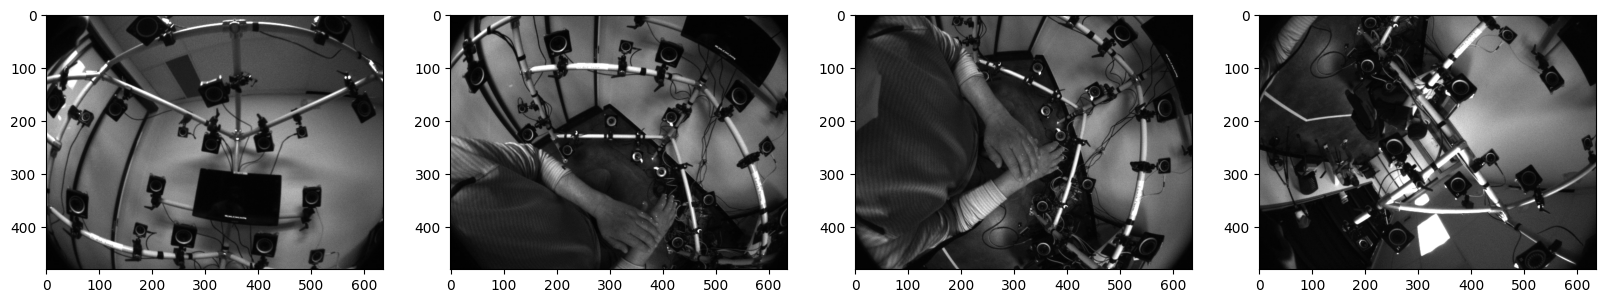

2 [[-9.03648511e-02  5.86615466e-02 -9.94179547e-01 -8.75907669e+01]
 [ 5.40197551e-01  8.41538072e-01  5.54275117e-04 -7.76728668e+01]
 [ 8.36672425e-01 -5.37003279e-01 -1.07734285e-01  2.90849342e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [14]:
idx = 20

input_frame, gt_tracking = image_pose_list[idx]

plt.figure(figsize=(20, 10))
for i, view in enumerate(input_frame.views):
    plt.subplot(1, len(input_frame.views), i+1)
    plt.imshow(view.image, cmap="gray")
plt.show()

print(len(gt_tracking), gt_tracking[0].wrist_xform)

In [15]:
keypoint_pos_3D = landmarks_from_hand_pose(
    image_pose_stream._hand_pose_labels.hand_model,
    gt_tracking[0],
    0
)

In [16]:
input_frame.views[0].camera.distortion_model._fields

('k1', 'k2', 'k3', 'k4', 'p1', 'p2', 'k5', 'k6')

In [24]:
print(input_frame.views[0].camera.distortion_model.k1)
print(input_frame.views[0].camera.distortion_model.k2)
print(input_frame.views[0].camera.distortion_model.k3)
print(input_frame.views[0].camera.distortion_model.k4)
print(input_frame.views[0].camera.distortion_model.p1)
print(input_frame.views[0].camera.distortion_model.p2)
print(input_frame.views[0].camera.distortion_model.k5)
print(input_frame.views[0].camera.distortion_model.k6)

_tuplegetter(0, 'Alias for field number 0')
_tuplegetter(1, 'Alias for field number 1')
_tuplegetter(2, 'Alias for field number 2')
_tuplegetter(3, 'Alias for field number 3')
_tuplegetter(4, 'Alias for field number 4')
_tuplegetter(5, 'Alias for field number 5')
_tuplegetter(6, 'Alias for field number 6')
_tuplegetter(7, 'Alias for field number 7')


# Visualize Input (image, annotation)

In [25]:
_ = """
def create_camera_visualization(ax, camera_to_world_xf):
    camera_pos = camera_to_world_xf[:3, 3]
    camera_x = camera_to_world_xf[:3, 0]
    camera_y = camera_to_world_xf[:3, 1]
    camera_z = camera_to_world_xf[:3, 2]
    
    ax.scatter(*camera_pos, color='red', s=50, label='Camera')
    
    scale = 10
    for axis, color in zip([camera_x, camera_y, camera_z], ['red', 'green', 'blue']):
        ax.quiver(*camera_pos, *axis, length=scale, color=color, linewidth=2)

def create_keypoint_visualization(ax, keypoint_pos_3D):
    print(keypoint_pos_3D.shape)
    # keypoint_pos_3D is 21 x 3
    # ax.scatter(
    #     keypoint_pos_3D[:, 0],
    #     keypoint_pos_3D[:, 1],
    #     keypoint_pos_3D[:, 2],
    #     color='blue',
    #     label='Keypoint'
    # )
    
    color_list = [
        'blue', 'green', 'red', 'cyan', 'magenta',
        'yellow', 'black', 'white', 'purple', 'orange',
        'brown', 'pink', 'gray', 'olive', 'cyan',
        'magenta', 'yellow', 'black', 'white', 'purple',
        'orange', # 'brown', 'pink', 'gray', 'olive'
    ]
    # plot each keypoints in different color
    ax.scatter(
        keypoint_pos_3D[:, 0],
        keypoint_pos_3D[:, 1],
        keypoint_pos_3D[:, 2],
        color=color_list,
        label='Keypoint'
    )
    

def update_plot(frame_idx):    
    input_frame, gt_tracking = image_pose_list[frame_idx]
    
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    for view in input_frame.views:
        create_camera_visualization(ax, view.camera.camera_to_world_xf)

    for hand_idx, gt_hand_pose in gt_tracking.items():
        keypoint_pos_3D = landmarks_from_hand_pose(
            image_pose_stream._hand_pose_labels.hand_model,
            gt_hand_pose,
            hand_idx
        )
        create_keypoint_visualization(ax, keypoint_pos_3D)
        break


    # for hand_idx, gt_hand_pose in gt_tracking.items():
    #     wrist_xform = gt_hand_pose.wrist_xform
    #     wrist_pos = wrist_xform[:3, 3]
    #     print(wrist_pos) 
    #     ax.scatter(*wrist_pos, color='blue', s=50, label=f'Wrist {hand_idx}')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f"Camera Positions and Orientations in World Coordinate System (Frame {frame_idx})")
    ax.legend()

    # Set equal aspect ratio for all axes
    ax.set_box_aspect((np.ptp(ax.get_xlim()), np.ptp(ax.get_ylim()), np.ptp(ax.get_zlim())))

    plt.tight_layout()
    
    fig_views, axs = plt.subplots(1, len(input_frame.views), figsize=(16, 4))
    for vid, view in enumerate(input_frame.views):
        axs[vid].imshow(view.image, cmap="gray")
        axs[vid].axis('off')
    plt.tight_layout()
    
    return fig, fig_views

# Use observe instead of interactive
def on_slider_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        with output:
            clear_output(wait=True)
            # matplotlib clear output
            plt.close()
            fig, fig_views = update_plot(change['new'])
            plt.show()

slider = IntSlider(
    min=0,
    max=len(image_pose_list) - 1,
    step=1,
    value=0,
    description='Frame Index:'
)

# Observe slider changes
slider.observe(on_slider_change)

# Create an output widget to display the plot
output = Output()

# Display the slider and output
display(slider, output)

# Manually trigger the initial update
with output:
    #fig, fig_views = update_plot(0)
    #plt.show()
    pass
"""

In [18]:
# Visualize camera's position and orientation in world coordinate system using plotly
import plotly.graph_objs as go
import numpy as np
from ipywidgets import interactive, IntSlider, Output
from IPython.display import clear_output

def create_camera_visualization(camera_to_world_xf):
    # Extract camera position (translation)
    camera_pos = camera_to_world_xf[:3, 3]
    
    # Extract camera orientation (rotation)
    camera_x = camera_to_world_xf[:3, 0]
    camera_y = camera_to_world_xf[:3, 1]
    camera_z = camera_to_world_xf[:3, 2]
    
    # Create camera position marker
    camera_marker = go.Scatter3d(
        x=[camera_pos[0]], y=[camera_pos[1]], z=[camera_pos[2]],
        mode='markers',
        marker=dict(size=8, color='red'),
        name='Camera'
    )
    
    # Create camera orientation arrows
    scale = 10  # Scale factor for orientation arrows
    arrows = []
    for axis, color in zip([camera_x, camera_y, camera_z], ['red', 'green', 'blue']):
        arrows.append(go.Scatter3d(
            x=[camera_pos[0], camera_pos[0] + scale * axis[0]],
            y=[camera_pos[1], camera_pos[1] + scale * axis[1]],
            z=[camera_pos[2], camera_pos[2] + scale * axis[2]],
            mode='lines',
            line=dict(color=color, width=3),
            name=f'{color.capitalize()} axis'
        ))
    
    return [camera_marker] + arrows

# Initialize an empty figure
fig = go.Figure()

def update_plot(frame_idx):
    input_frame, gt_tracking = image_pose_list[frame_idx]
    
    # Clear previous traces
    fig.data = []
    
    # Add camera visualizations for each view
    for i, view in enumerate(input_frame.views):
        camera_vis = create_camera_visualization(
            view.camera.camera_to_world_xf
        )
        for trace in camera_vis:
            fig.add_trace(trace)

    # wrist_xform : root-to-world wrist transform
    # assume that the unit is millimeter
    for hand_idx, gt_hand_pose in gt_tracking.items():
        wrist_xform = gt_hand_pose.wrist_xform
        wrist_pos = wrist_xform[:3, 3]
        
        # Add wrist marker
        wrist_marker = go.Scatter3d(
            x=[wrist_pos[0]], y=[wrist_pos[1]], z=[wrist_pos[2]],
            mode='markers',
            marker=dict(size=8, color='blue'),
            name=f'Wrist {hand_idx}'
        )
        fig.add_trace(wrist_marker)
        
        # Add 3D hand keypoints
        
        keypoints = landmarks_from_hand_pose(
            image_pose_stream._hand_pose_labels.hand_model,
            gt_hand_pose,
            hand_idx
        )
        x_coords, y_coords, z_coords = [], [], []
        for kp in keypoints:
            x_coords.append(kp[0])
            y_coords.append(kp[1])
            z_coords.append(kp[2])
        
        keypoints_scatter = go.Scatter3d(
            x=x_coords, y=y_coords, z=z_coords,
            mode='markers',
            marker=dict(size=5, color='green' if hand_idx == 0 else 'red'),
            name=f'Hand {hand_idx} Keypoints'
        )
        fig.add_trace(keypoints_scatter)
        
        # Add lines connecting keypoints (you may need to adjust this based on your keypoint order)
        for i in range(len(keypoints) - 1):
            line = go.Scatter3d(
                x=[keypoints[i][0], keypoints[i+1][0]],
                y=[keypoints[i][1], keypoints[i+1][1]],
                z=[keypoints[i][2], keypoints[i+1][2]],
                mode='lines',
                line=dict(color='cyan', width=2),
                name=f'Hand {hand_idx} Bone'
            )
            fig.add_trace(line)

    # Set layout
    fig.update_layout(
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
            aspectmode='data'
        ),
        title=f"Camera Positions, Hand Keypoints, and Orientations in World Coordinate System (Frame {frame_idx})",
        legend_title="Legend",
        height=800,
        width=1000
    )

    return fig

INIT_FRAME_IDX = 300

# Create a slider widget
slider = IntSlider(
    min=0,
    max=len(image_pose_list) - 1,
    step=1,
    value=INIT_FRAME_IDX,
    description='Frame Index:'
)

# Create an output widget to display the plot
output = Output()

# Create an interactive widget
def update_output(frame_idx):
    with output:
        clear_output(wait=True)
        fig = update_plot(frame_idx)
        fig.show()
        
        plt.figure(figsize=(30, 10))
        for vid, view in enumerate(
            image_pose_list[frame_idx][0].views
        ):
            plt.subplot(1, len(input_frame.views), vid+1)
            plt.imshow(view.image, cmap="gray")
        plt.show()
        
interactive_plot = interactive(update_output, frame_idx=slider)

# Display the interactive widget and output
display(interactive_plot, output)

interactive(children=(IntSlider(value=300, description='Frame Index:', max=368), Output()), _dom_classes=('wid…

Output()

In [18]:
# Visualize camera's position and orientation in world coordinate system using plotly
import plotly.graph_objs as go
import numpy as np
from ipywidgets import interactive, IntSlider, Output
from IPython.display import clear_output

def create_camera_visualization(camera_to_world_xf):
    # Extract camera position (translation)
    camera_pos = camera_to_world_xf[:3, 3]
    
    # Extract camera orientation (rotation)
    camera_x = camera_to_world_xf[:3, 0]
    camera_y = camera_to_world_xf[:3, 1]
    camera_z = camera_to_world_xf[:3, 2]
    
    # Create camera position marker
    camera_marker = go.Scatter3d(
        x=[camera_pos[0]], y=[camera_pos[1]], z=[camera_pos[2]],
        mode='markers',
        marker=dict(size=8, color='red'),
        name='Camera'
    )
    
    # Create camera orientation arrows
    scale = 10  # Scale factor for orientation arrows
    arrows = []
    for axis, color in zip([camera_x, camera_y, camera_z], ['red', 'green', 'blue']):
        arrows.append(go.Scatter3d(
            x=[camera_pos[0], camera_pos[0] + scale * axis[0]],
            y=[camera_pos[1], camera_pos[1] + scale * axis[1]],
            z=[camera_pos[2], camera_pos[2] + scale * axis[2]],
            mode='lines',
            line=dict(color=color, width=3),
            name=f'{color.capitalize()} axis'
        ))
    
    return [camera_marker] + arrows

# Initialize an empty figure
fig = go.Figure()

def update_plot(frame_idx):
    input_frame, gt_tracking = image_pose_list[frame_idx]
    
    # Clear previous traces
    fig.data = []
    
    # Add camera visualizations for each view
    for i, view in enumerate(input_frame.views):
        camera_vis = create_camera_visualization(
            view.camera.camera_to_world_xf
        )
        for trace in camera_vis:
            fig.add_trace(trace)

    # wrist_xform : root-to-world wrist transform
    # assume that the unnit is millimeter
    for hand_idx, gt_hand_pose in gt_tracking.items() :
        wrist_xform = gt_hand_pose.wrist_xform
        wrist_pos = wrist_xform[:3, 3]
        print(wrist_pos)
        print()
        wrist_x = wrist_xform[:3, 0]
        wrist_y = wrist_xform[:3, 1]
        wrist_z = wrist_xform[:3, 2]
        
        wrist_marker = go.Scatter3d(
            x=[wrist_pos[0]], y=[wrist_pos[1]], z=[wrist_pos[2]],
            mode='markers',
            marker=dict(size=8, color='blue'),
            name=f'Wrist {hand_idx}'
        )
        fig.add_trace(wrist_marker)
        

    # Set layout
    fig.update_layout(
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
            aspectmode='data'
        ),
        title=f"Camera Positions and Orientations in World Coordinate System (Frame {frame_idx})",
        legend_title="Legend",
        height=800,
        width=1000
    )

    return fig

INIT_FRAME_IDX = 100

# Create a slider widget
slider = IntSlider(
    min=0,
    max=len(image_pose_list) - 1,
    step=1,
    value=INIT_FRAME_IDX,
    description='Frame Index:'
)

# Create an output widget to display the plot
output = Output()

# Create an interactive widget
def update_output(frame_idx):
    with output:
        clear_output(wait=True)
        fig = update_plot(frame_idx)
        fig.show()
        
        plt.figure(figsize=(30, 10))
        for vid, view in enumerate(
            image_pose_list[frame_idx][0].views
        ):
            plt.subplot(1, len(input_frame.views), vid+1)
            plt.imshow(view.image, cmap="gray")
        plt.show()
        
interactive_plot = interactive(update_output, frame_idx=slider)

# Display the interactive widget and output
display(interactive_plot, output)

interactive(children=(IntSlider(value=100, description='Frame Index:', max=368), Output()), _dom_classes=('wid…

Output()

In [14]:

for (input_frame, gt_tracking) in image_pose_list :
    # check if Z axis of second and third camera are parallel
    
    print(
        "cosine between Z axis of second and third camera : ",
        #np.sqrt(np.sum(np.square(input_frame.views[1].camera.camera_to_world_xf[:3, 2]))),
        #np.sqrt(np.sum(np.square(input_frame.views[2].camera.camera_to_world_xf[:3, 2]))),
        np.dot(
            input_frame.views[1].camera.camera_to_world_xf[:3, 2],
            input_frame.views[2].camera.camera_to_world_xf[:3, 2]
        )
    )
    
    
    print(
        "cosine between Z axis of first camera and second camera : ",
        np.dot(
            input_frame.views[0].camera.camera_to_world_xf[:3, 2],
            input_frame.views[1].camera.camera_to_world_xf[:3, 2]
        )
    )

    print(np.dot(
        np.cross(
            input_frame.views[0].camera.camera_to_world_xf[:3, 2],
            input_frame.views[1].camera.camera_to_world_xf[:3, 2],
        ),
        np.cross(
            input_frame.views[2].camera.camera_to_world_xf[:3, 2],
            input_frame.views[3].camera.camera_to_world_xf[:3, 2],
        )
    ))
    
    print()

cosine between Z axis of second and third camera :  0.93913318284371
cosine between Z axis of first camera and second camera :  0.10822279016363012
0.1863964763927823

cosine between Z axis of second and third camera :  0.9391330651068094
cosine between Z axis of first camera and second camera :  0.10822287864555946
0.18639641535815857

cosine between Z axis of second and third camera :  0.9391329347847919
cosine between Z axis of first camera and second camera :  0.10822285171015977
0.1863964362037213

cosine between Z axis of second and third camera :  0.9391332241952846
cosine between Z axis of first camera and second camera :  0.10822271227240421
0.18639644393317267

cosine between Z axis of second and third camera :  0.9391333840794266
cosine between Z axis of first camera and second camera :  0.10822274957475031
0.18639650326270205

cosine between Z axis of second and third camera :  0.9391331347045011
cosine between Z axis of first camera and second camera :  0.10822292074567219

# Run model in dataset
- Visualize warping and hand flip

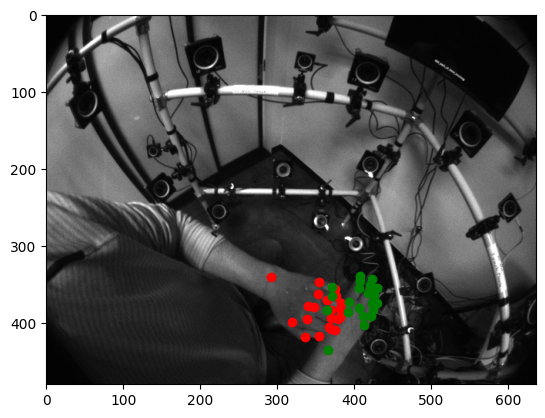

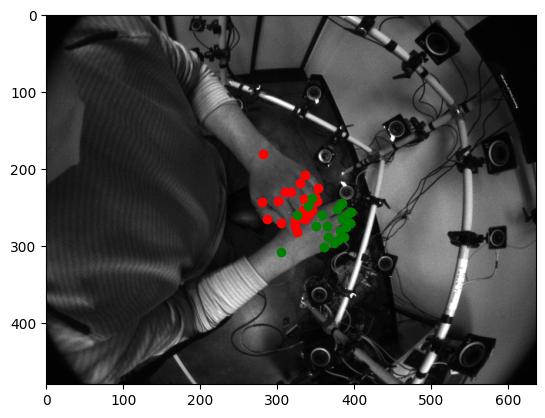

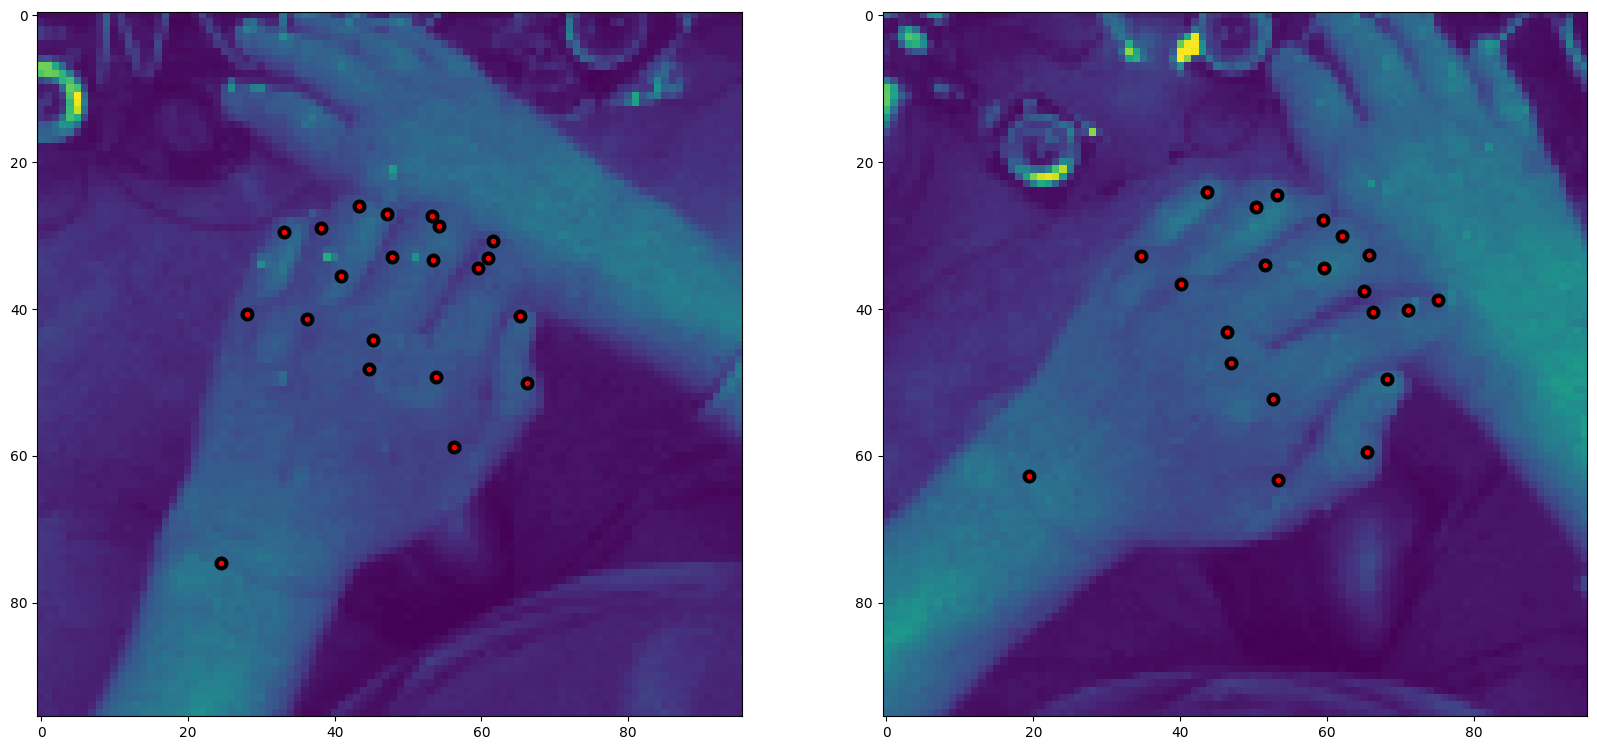

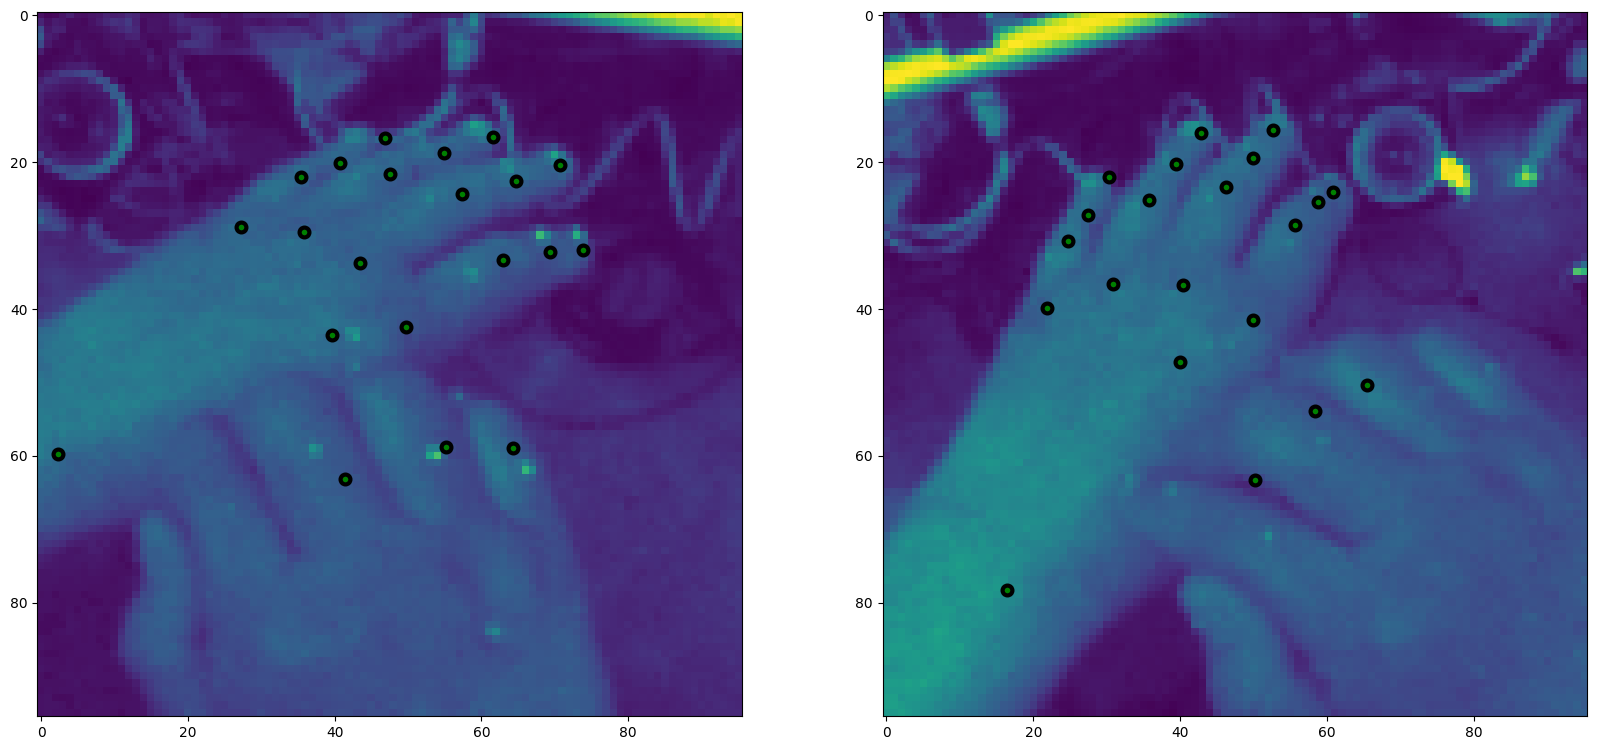

In [84]:
model_name = "pretrained_weights.torch"
model_path = os.path.join(".", "pretrained_models", model_name)
model = load_pretrained_model(model_path)
model.eval()
tracker1 = HandTracker(model, HandTrackerOpts())
tracker2 = HandTracker(model, HandTrackerOpts())


FRAME_IDX = 29

input_frame, gt_tracking = image_pose_list[FRAME_IDX]


crop_cameras = tracker1.gen_crop_cameras(
    [view.camera for view in input_frame.views],
    image_pose_stream._hand_pose_labels.camera_angles,
    hand_model,
    gt_tracking,
    min_num_crops=1,
)

# ==============================================
# visualizes gt_hand_pose and whole image
# for each camera, find if hand is projected to this camera
# if so, visualize the keypoints on the image
for camera_idx in range(len(input_frame.views)) :
    orig_camera = input_frame.views[camera_idx].camera
    keypoints_window_list = []
    # find if crop_camera is generated to this camera
    for hand_idx, crop_camera_dict in crop_cameras.items() :
        if camera_idx in crop_camera_dict.keys() :
            hand_pose = gt_tracking[hand_idx]
            keypoints_world = landmarks_from_hand_pose(
                hand_model,
                hand_pose,
                hand_idx
            )
            keypoints_eye = orig_camera.world_to_eye(keypoints_world)
            keypoints_window = orig_camera.eye_to_window(keypoints_eye)
            keypoints_window_list.append(keypoints_window)
    
    color_list = ['r', 'g', 'b', 'y', 'm', 'c'] 
    if len(keypoints_window_list) > 0 :
        plt.imshow(input_frame.views[camera_idx].image, cmap="gray")
        for i in range(len(keypoints_window_list)) :
            plt.scatter(
                keypoints_window_list[i][:, 0],
                keypoints_window_list[i][:, 1],
                color=color_list[i],
                label='Keypoint'
            )
        plt.show()
        



res = tracker1.track_frame_analysis(input_frame, hand_model, crop_cameras, gt_tracking)
res_orig = tracker2.track_frame(input_frame, hand_model, crop_cameras)

### Try to run mediapipe hand model on datset

In [86]:
# mediapie does not work well on monochrome image
_ = """
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
hands = mp_hands.Hands(
    max_num_hands = 2,
    
    model_complexity = 1,
    min_detection_confidence = 0.3, 
    min_tracking_confidence = 0.3
)

def visualize_frame(frame_idx):
    input_frame, gt_tracking = image_pose_list[frame_idx]
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    axes = axes.flatten()
    
    for i, frame in enumerate(input_frame.views):
        frame_rgb = cv2.cvtColor(frame.image, cv2.COLOR_GRAY2RGB)
        axes[i].imshow(frame_rgb)
        axes[i].set_title(f"View {i+1}")
        
        mp_result = hands.process(frame_rgb)
        if mp_result.multi_handedness:
            axes[i].set_xlabel(f"{len(mp_result.multi_handedness)} Hand detected")
            for hand_landmarks in mp_result.multi_hand_landmarks:
                hand_landmarks_norm_np = np.array(list(map(
                    lambda l : [l.x, l.y, l.z],
                    hand_landmarks.landmark
                )))
                hand_landmarks_np = hand_landmarks_norm_np * np.array([frame.camera.width, frame.camera.height, 1])
                
                axes[i].scatter(
                    hand_landmarks_np[:, 0],
                    hand_landmarks_np[:, 1],
                    color='blue',
                    label='Keypoint'
                )
        else:
            axes[i].set_xlabel("No hand detected")
    
    plt.tight_layout()
    plt.show()

slider = IntSlider(
    min=0,
    max=len(image_pose_list) - 1,
    step=1,
    value=0,
    description='Frame Index:'
)

output = Output()

interactive_plot = interactive(visualize_frame, frame_idx=slider)
display(interactive_plot, output)
"""

# Play with Tracker

In [20]:
model_name = "pretrained_weights.torch"
model_path = os.path.join(".", "pretrained_models", model_name)
model = load_pretrained_model(model_path)
model.eval()
tracker = HandTracker(model, HandTrackerOpts())


In [21]:
tracker = HandTracker(model, HandTrackerOpts())
crop_cameras = tracker.gen_crop_cameras(
    [view.camera for view in input_frame.views],
    image_pose_stream._hand_pose_labels.camera_angles,
    hand_model,
    gt_tracking,
    min_num_crops=1,
)
crop_cameras


{0: {1: PinholePlaneCameraModel(96x96, f=(128.55036772749628, 128.55036772749628) c=(47.5, 47.5),
  2: PinholePlaneCameraModel(96x96, f=(125.8543751900728, 125.8543751900728) c=(47.5, 47.5)},
 1: {1: PinholePlaneCameraModel(96x96, f=(185.7430426884762, 185.7430426884762) c=(47.5, 47.5),
  2: PinholePlaneCameraModel(96x96, f=(166.3888636471937, 166.3888636471937) c=(47.5, 47.5)}}

In [22]:
tracker = HandTracker(model, HandTrackerOpts())

crop_cameras = tracker.gen_crop_cameras_analysis(
    #[view.camera for view in input_frame.views],
    input_frame     = input_frame,
    camera_angles   = image_pose_stream._hand_pose_labels.camera_angles,
    hand_model      = hand_model,
    gt_tracking     = gt_tracking,
    min_num_crops   = 1,
)

print(crop_cameras)
print()

crop_cameras = tracker.gen_crop_cameras(
    [view.camera for view in input_frame.views],
    image_pose_stream._hand_pose_labels.camera_angles,
    hand_model,
    gt_tracking,
    min_num_crops=1,
)
print(crop_cameras)

{0: {1: PinholePlaneCameraModel(96x96, f=(128.55036772749628, 128.55036772749628) c=(47.5, 47.5), 2: PinholePlaneCameraModel(96x96, f=(125.8543751900728, 125.8543751900728) c=(47.5, 47.5)}, 1: {1: PinholePlaneCameraModel(96x96, f=(185.7430426884762, 185.7430426884762) c=(47.5, 47.5), 2: PinholePlaneCameraModel(96x96, f=(166.3888636471937, 166.3888636471937) c=(47.5, 47.5)}}

{0: {1: PinholePlaneCameraModel(96x96, f=(128.55036772749628, 128.55036772749628) c=(47.5, 47.5), 2: PinholePlaneCameraModel(96x96, f=(125.8543751900728, 125.8543751900728) c=(47.5, 47.5)}, 1: {1: PinholePlaneCameraModel(96x96, f=(185.7430426884762, 185.7430426884762) c=(47.5, 47.5), 2: PinholePlaneCameraModel(96x96, f=(166.3888636471937, 166.3888636471937) c=(47.5, 47.5)}}


In [24]:
res = tracker.track_frame(input_frame, hand_model, crop_cameras)

## Put ELP Stereo Camera

In [87]:

IMG_WIDTH = 640
IMG_HEIGHT = 480

left_to_right_r = np.array([
    9.9997658245714527e-01, 5.5910744958795095e-04, 6.8206990981942916e-03,
    -5.4903304536865717e-04, 9.9999875583076248e-01, -1.4788169738349651e-03,
    -6.8215174296769373e-03, 1.4750375543776898e-03, 9.9997564528550886e-01
]).reshape(3, 3)

left_to_right_t = np.array([
    -5.9457914254177978e-02, -6.8318101539255457e-05, -1.8101725187729225e-04
])

# k1, k2, k3, k4, p1, p2, k5, k6
distortion_coeffs_left = (
    -3.7539305827469560e-02, 
    -8.7553205432575471e-03,
    2.2015408171895236e-03, 
    -6.6218076061138698e-04,
    0, 0, 0, 0
)
camera_to_world_xf_left = np.eye(4)
rotation_left = np.array([
    [9.9997658245714527e-01,  5.5910744958795095e-04,  6.8206990981942916e-03,],
    [-5.4903304536865717e-04, 9.9999875583076248e-01, -1.4788169738349651e-03,],
    [-6.8215174296769373e-03, 1.4750375543776898e-03,  9.9997564528550886e-01 ],
]).reshape(3, 3)
camera_to_world_xf_left[:3, :3] = rotation_left
#camera_to_world_xf_left[:3, 3] = [
cam_left = Fisheye62CameraModel(
    width   = IMG_WIDTH,
    height  = IMG_HEIGHT,
    f       = (2.3877057700850656e+02, 2.3903223316525276e+02),
    c       = (3.1846939219741773e+02, 2.4685137381795201e+02),
    distort_coeffs = distortion_coeffs_left,
    camera_to_world_xf = np.eye(4)
)


distortion_coeffs_right = (
    -3.6790400486095221e-02, 
    -8.2041573433038941e-03,
    1.0552974220937024e-03, 
    -2.5841665172692902e-04,
    0, 0, 0, 0
)
camera_to_world_xf_right = np.eye(4)
rotation_right = np.array([
    [9.9999470555416226e-01, 1.1490100298631428e-03, 3.0444440536135159e-03,],
    [-1.1535052313709361e-03, 9.9999824663038117e-01, 1.4751819698614872e-03,],
    [-3.0427437166985561e-03, -1.4786859417328980e-03, 9.9999427758290704e-01 ],
]).reshape(3, 3)
camera_to_world_xf_right[:3, :3] = rotation_right
camera_to_world_xf_right[:3, 3] = left_to_right_t
#camera_to_world_xf_right[:3, 3] = [
cam_right = Fisheye62CameraModel(
    width   = IMG_WIDTH,
    height  = IMG_HEIGHT,
    f       = (2.3952183485043457e+02, 2.3981379751051574e+02),
    c       = (3.1286224145189811e+02, 2.5158397962108106e+02),
    distort_coeffs = distortion_coeffs_right,
    camera_to_world_xf = camera_to_world_xf_right
)

def open_stereo_camera(IMAGE_WIDTH, IMAGE_HEIGHT, CAM_ID_MAX = 10) :
    for CAM_ID in range(-1, CAM_ID_MAX) :
        cap = cv2.VideoCapture(CAM_ID)
        cap.set(cv2.CAP_PROP_FRAME_WIDTH, IMAGE_WIDTH * 2)
        cap.set(cv2.CAP_PROP_FRAME_HEIGHT, IMAGE_HEIGHT)
        if cap.isOpened() :
            print(f"Camera ID {CAM_ID} Frame Width {cap.get(cv2.CAP_PROP_FRAME_WIDTH)}")
            return cap

CAM_ID_MAX = 10


In [88]:
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
hands_left_cam = mp_hands.Hands(
    max_num_hands = 2,
    model_complexity = 1,
    min_detection_confidence = 0.3, 
    min_tracking_confidence = 0.3
)

hands_right_cam = mp_hands.Hands(
    max_num_hands = 2,   
    model_complexity = 1,
    min_detection_confidence = 0.3, 
    min_tracking_confidence = 0.3
)

I0000 00:00:1724995915.929939  127522 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1724995916.052658  129782 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.183.06), renderer: NVIDIA GeForce RTX 3060/PCIe/SSE2
I0000 00:00:1724995916.058122  127522 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
W0000 00:00:1724995916.068051  129773 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1724995916.089218  129777 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1724995916.109428  129799 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.183.06), renderer: NVIDIA GeForce RTX 3060/PCIe/SSE2


W0000 00:00:1724995916.124607  129795 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1724995916.144209  129784 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Camera ID -1 Frame Width 1280.0
left cam detected hand index :  0 1
right cam detected hand index :  0 1
0
1


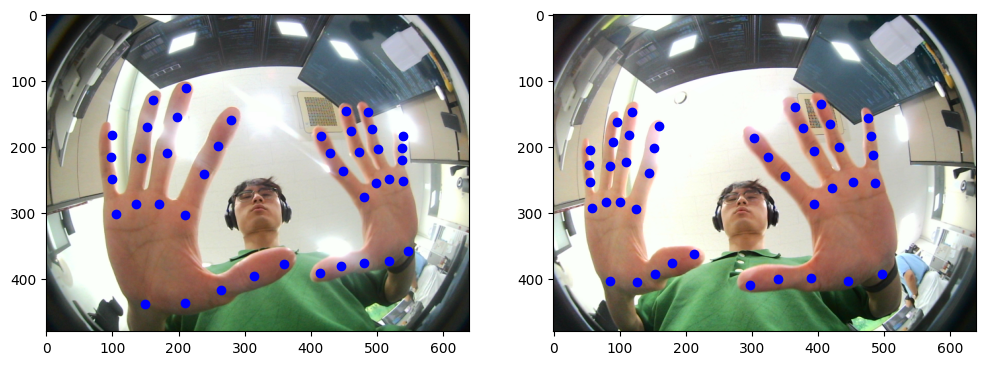

In [148]:
cap = open_stereo_camera(IMG_WIDTH, IMG_HEIGHT, CAM_ID_MAX)
ret, frame_stereo = cap.read()
frame_stereo = cv2.cvtColor(frame_stereo, cv2.COLOR_BGR2RGB)
frame_left = frame_stereo[:, :IMG_WIDTH]
frame_right = frame_stereo[:, IMG_WIDTH:]
frame_right_gray = cv2.cvtColor(frame_right, cv2.COLOR_RGB2GRAY)
frame_left_gray = cv2.cvtColor(frame_left, cv2.COLOR_RGB2GRAY)
cap.release()

hand_pose_result_left_cam = hands_left_cam.process(frame_left)
# key : handedness index
# value : window coordinate hand pose
if hand_pose_result_left_cam.multi_handedness :
    hand_pose_window_left_cam : Dict[int, np.ndarray] = dict(zip(
        list(map(
            lambda x : x.classification[0].index,
            hand_pose_result_left_cam.multi_handedness
        )),
        list(map(
            lambda landamrk_per_hand : np.array(list(map(
                lambda l : [l.x, l.y, l.z],
                landamrk_per_hand.landmark
            ))) * np.array([frame_left.shape[1], frame_left.shape[0], 1]),
            hand_pose_result_left_cam.multi_hand_landmarks
        ))
    ))
print("left cam detected hand index : ", *hand_pose_window_left_cam.keys())

hand_pose_result_right_cam = hands_right_cam.process(frame_right)
if hand_pose_result_right_cam.multi_handedness :
    hand_pose_window_right_cam : Dict[int, np.ndarray] = dict(zip(
        list(map(
            lambda x : x.classification[0].index,
            hand_pose_result_right_cam.multi_handedness
        )),
        list(map(
            lambda landamrk_per_hand : np.array(list(map(
                lambda l : [l.x, l.y, l.z],
                landamrk_per_hand.landmark
            ))) * np.array([frame_right.shape[1], frame_right.shape[0], 1]),
            hand_pose_result_right_cam.multi_hand_landmarks
        ))
    ))
    hand_pose_window_right_cam
print("right cam detected hand index : ", *hand_pose_window_right_cam.keys())

VIS_HAND_IDX_LIST = [0, 1]\
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(frame_left)
for hand_idx in VIS_HAND_IDX_LIST :
    if hand_idx in hand_pose_window_left_cam :
        print(hand_idx)
        plt.scatter(
            hand_pose_window_left_cam[hand_idx][:, 0],
            hand_pose_window_left_cam[hand_idx][:, 1],
            color='blue',
            label='Keypoint'
        )

plt.subplot(1, 2, 2)
plt.imshow(frame_right)
for hand_idx in VIS_HAND_IDX_LIST :
    if hand_idx in hand_pose_window_right_cam :
        plt.scatter(
            hand_pose_window_right_cam[hand_idx][:, 0],
            hand_pose_window_right_cam[hand_idx][:, 1],
            color='blue',
            label='Keypoint'
    )   
plt.show()

0
1


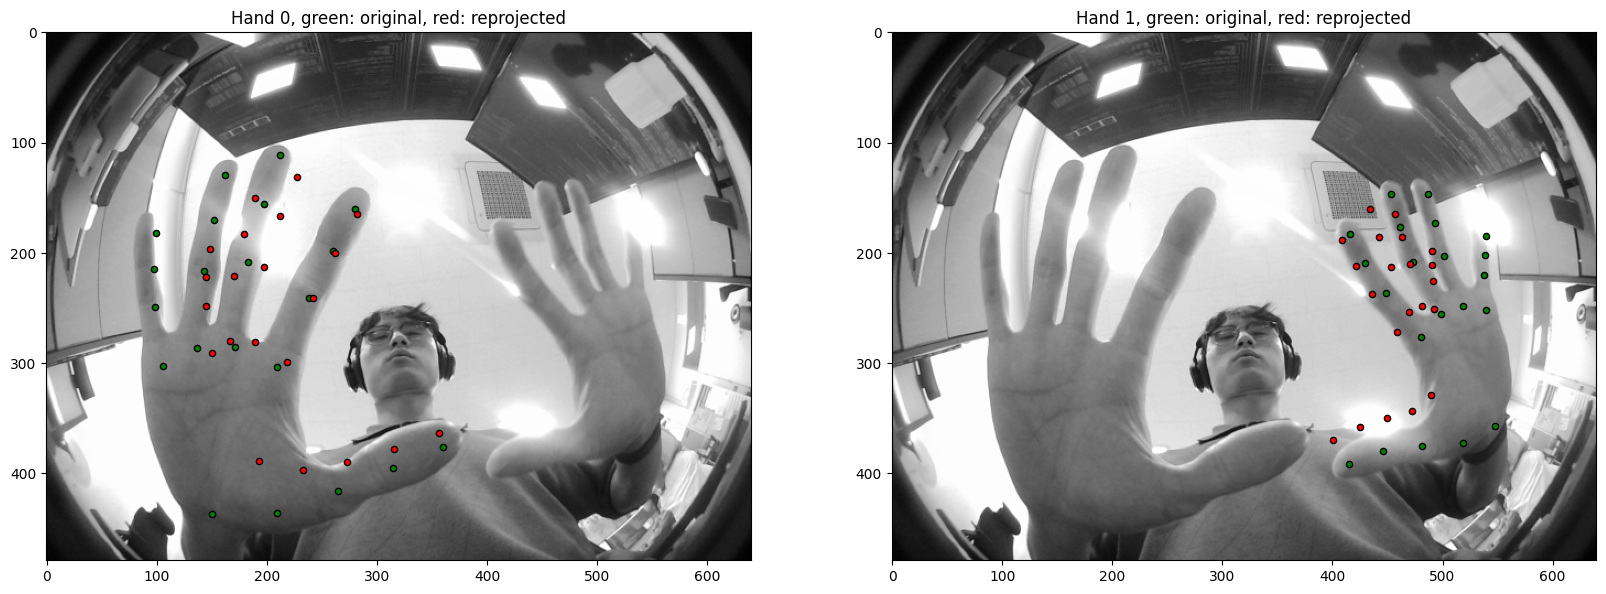

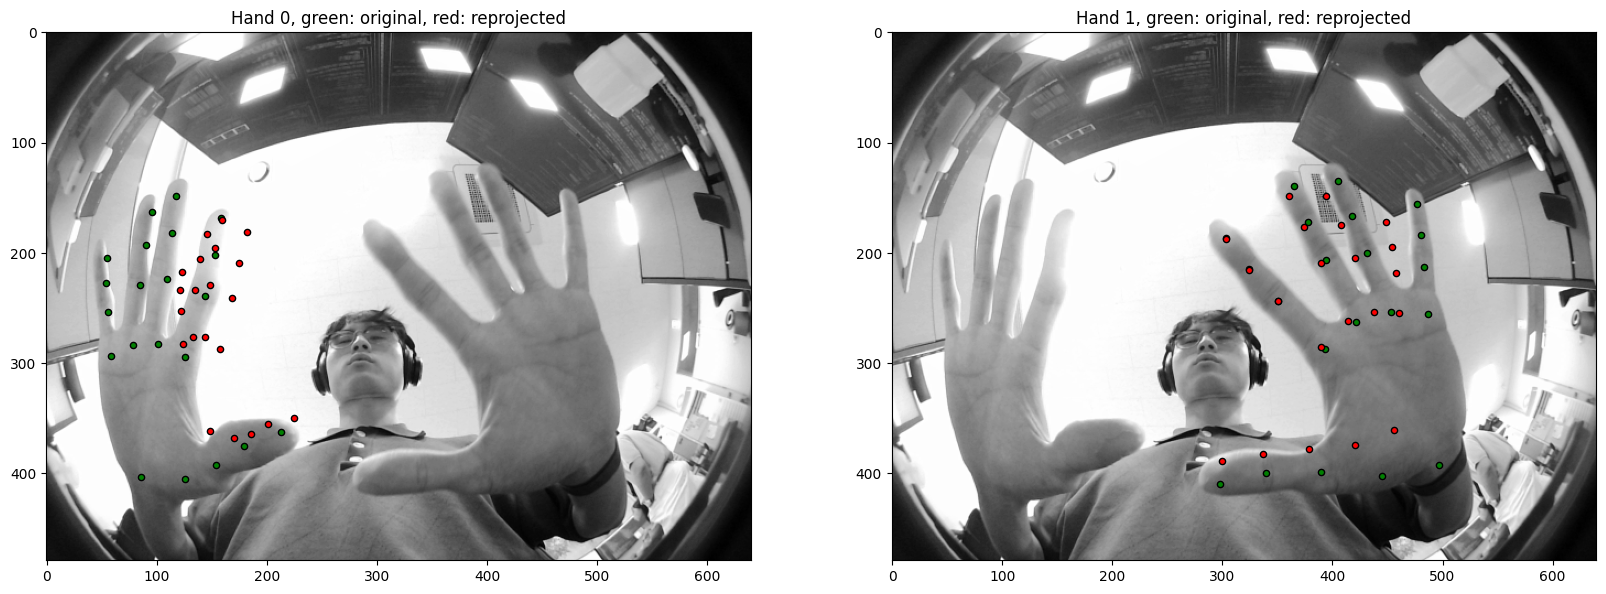

In [150]:
model_name = "pretrained_weights.torch"
model_path = os.path.join(".", "pretrained_models", model_name)
model = load_pretrained_model(model_path)
model.eval()
tracker = HandTracker(model, HandTrackerOpts())

crop_camera_dict = tracker.gen_crop_cameras_from_stereo_camera_with_window_hand_pose(
    camera_left = cam_left,
    camera_right = cam_right,
    window_hand_pose_left = hand_pose_window_left_cam,
    window_hand_pose_right = hand_pose_window_right_cam
)
crop_camera_dict

fisheye_stereo_input_frame = InputFrame(
    views = [
        ViewData(
            image = frame_left_gray,
            camera = cam_left,
            camera_angle = 0,
        ),
        ViewData(
            image = frame_right_gray,
            camera = cam_right,
            camera_angle = 0,
        )
    ]
)
tracker.visualize_crop_cameras(
    input_frame = fisheye_stereo_input_frame,
    window_hand_pose_left = hand_pose_window_left_cam,
    window_hand_pose_right = hand_pose_window_right_cam,
    crop_camera_dict = crop_camera_dict
)

In [155]:
print(fisheye_stereo_input_frame.views[0].camera)
print(fisheye_stereo_input_frame.views[0].camera.camera_to_world_xf)

print()

print(fisheye_stereo_input_frame.views[1].camera)
print(fisheye_stereo_input_frame.views[1].camera.camera_to_world_xf)



Fisheye62CameraModel(640x480, f=(238.77057700850656, 239.03223316525276) c=(318.46939219741773, 246.851373817952)
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]

Fisheye62CameraModel(640x480, f=(239.52183485043457, 239.81379751051574) c=(312.8622414518981, 251.58397962108106)
[[ 9.99994706e-01  1.14901003e-03  3.04444405e-03 -5.94579143e-02]
 [-1.15350523e-03  9.99998247e-01  1.47518197e-03 -6.83181015e-05]
 [-3.04274372e-03 -1.47868594e-03  9.99994278e-01 -1.81017252e-04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [97]:
res = tracker.track_frame_analysis(fisheye_stereo_input_frame, hand_model, crop_camera_dict)

TypeError: track_frame_analysis() missing 1 required positional argument: 'gt_tracking'

In [48]:
tracked_keypoints_dict = {}
for hand_idx in res.hand_poses.keys() :
    tracked_keypoints = landmarks_from_hand_pose(
        hand_model, res.hand_poses[hand_idx], hand_idx
    )
    tracked_keypoints_dict[hand_idx] = tracked_keypoints

camera_left_pose = cam_left.camera_to_world_xf[:3, 3] * M_TO_MM
camera_left_x_axis = cam_left.camera_to_world_xf[:3, 0] * M_TO_MM
camera_left_y_axis = cam_left.camera_to_world_xf[:3, 1] * M_TO_MM 
camera_left_z_axis = cam_left.camera_to_world_xf[:3, 2] * M_TO_MM

camera_right_pose = cam_right.camera_to_world_xf[:3, 3] * M_TO_MM
camera_right_x_axis = cam_right.camera_to_world_xf[:3, 0] * M_TO_MM
camera_right_y_axis = cam_right.camera_to_world_xf[:3, 1] * M_TO_MM
camera_right_z_axis = cam_right.camera_to_world_xf[:3, 2] * M_TO_MM

print(camera_left_pose)
print(camera_right_pose)
# visualize tracked_keypoints_dict, camera_left, camera_right using plotly

import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x = tracked_keypoints_dict[0][:, 0],
    y = tracked_keypoints_dict[0][:, 1],
    z = tracked_keypoints_dict[0][:, 2],
    mode = 'markers',
    marker = dict(
        size = 5,
        color = 'blue',
        opacity = 0.5
    )
))
fig.add_trace(go.Scatter3d(
    x = tracked_keypoints_dict[1][:, 0],
    y = tracked_keypoints_dict[1][:, 1],
    z = tracked_keypoints_dict[1][:, 2],
    mode = 'markers',
    marker = dict(
        size = 5,
        color = 'red',
        opacity = 0.5
    )
))

# add camera axis 
fig.add_trace(go.Scatter3d(
    x = [0, camera_left_x_axis[0]],
    y = [0, camera_left_x_axis[1]],
    z = [0, camera_left_x_axis[2]],
    mode = 'lines',
    line = dict(
        color = 'red',
        width = 5
    )
))
fig.add_trace(go.Scatter3d(
    x = [0, camera_left_y_axis[0]],
    y = [0, camera_left_y_axis[1]],
    z = [0, camera_left_y_axis[2]],
    mode = 'lines',
    line = dict(
        color = 'green',
        width = 5
    )
))
fig.add_trace(go.Scatter3d(
    x = [0, camera_left_z_axis[0]],
    y = [0, camera_left_z_axis[1]],
    z = [0, camera_left_z_axis[2]],
    mode = 'lines',
    line = dict(
        color = 'blue',
        width = 5
    )
))
fig.add_trace(go.Scatter3d(
    x = [0, camera_right_x_axis[0]],
    y = [0, camera_right_x_axis[1]],
    z = [0, camera_right_x_axis[2]],
    mode = 'lines',
    line = dict(
        color = 'red',
        width = 5
    )
))
fig.add_trace(go.Scatter3d(
    x = [0, camera_right_y_axis[0]],
    y = [0, camera_right_y_axis[1]],
    z = [0, camera_right_y_axis[2]],
    mode = 'lines',
    line = dict(
        color = 'green',
        width = 5
    )
))
fig.add_trace(go.Scatter3d(
    x = [0, camera_right_z_axis[0]],
    y = [0, camera_right_z_axis[1]],
    z = [0, camera_right_z_axis[2]],
    mode = 'lines',
    line = dict(
        color = 'blue',
        width = 5
    )
))

fig.show()

[[1000.    0.    0.]
 [   0. 1000.    0.]
 [   0.    0. 1000.]]
[[999.99470555   1.14901003   3.04444405]
 [ -1.15350523 999.99824663   1.47518197]
 [ -3.04274372  -1.47868594 999.99427758]]


In [39]:
# Joint Altogether

import socket

cap = open_stereo_camera(IMG_WIDTH, IMG_HEIGHT, CAM_ID_MAX)

model_name = "pretrained_weights.torch"
model_path = os.path.join(".", "pretrained_models", model_name)
model = load_pretrained_model(model_path)
model.eval()
tracker = HandTracker(model, HandTrackerOpts())

sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
serverAddressPort = ("127.0.0.1", 5052)

idx = 0

while True :
    idx += 1
    
    ret, frame_stereo = cap.read()
    frame_stereo = cv2.cvtColor(frame_stereo, cv2.COLOR_BGR2RGB)
    frame_left = frame_stereo[:, :IMG_WIDTH]
    frame_right = frame_stereo[:, IMG_WIDTH:]
    frame_right_gray = cv2.cvtColor(frame_right, cv2.COLOR_RGB2GRAY)
    frame_left_gray = cv2.cvtColor(frame_left, cv2.COLOR_RGB2GRAY)

    hand_pose_result_left_cam = hands_left_cam.process(frame_left)
    if hand_pose_result_left_cam.multi_handedness :
        hand_pose_window_left_cam : Dict[int, np.ndarray] = dict(zip(
            list(map(
                lambda x : x.classification[0].index,
                hand_pose_result_left_cam.multi_handedness
            )),
            list(map(
                lambda landamrk_per_hand : np.array(list(map(
                    lambda l : [l.x, l.y, l.z],
                    landamrk_per_hand.landmark
                ))) * np.array([frame_left.shape[1], frame_left.shape[0], 1]),
                hand_pose_result_left_cam.multi_hand_landmarks
            ))
        ))

    hand_pose_result_right_cam = hands_right_cam.process(frame_right)
    if hand_pose_result_right_cam.multi_handedness :
        hand_pose_window_right_cam : Dict[int, np.ndarray] = dict(zip(
            list(map(
                lambda x : x.classification[0].index,
                hand_pose_result_right_cam.multi_handedness
            )),
            list(map(
                lambda landamrk_per_hand : np.array(list(map(
                    lambda l : [l.x, l.y, l.z],
                    landamrk_per_hand.landmark
                ))) * np.array([frame_right.shape[1], frame_right.shape[0], 1]),
                hand_pose_result_right_cam.multi_hand_landmarks
            ))
        ))
        hand_pose_window_right_cam

    fisheye_stereo_input_frame = InputFrame(
        views = [
            ViewData(
                image = frame_left_gray,
                camera = cam_left,
                camera_angle = 0,
            ),
            ViewData(
                image = frame_right_gray,
                camera = cam_right,
                camera_angle = 0,
            )
        ]
    )

    crop_camera_dict = tracker.gen_crop_cameras_from_stereo_camera_with_window_hand_pose(
        camera_left = cam_left,
        camera_right = cam_right,
        window_hand_pose_left = hand_pose_window_left_cam,
        window_hand_pose_right = hand_pose_window_right_cam
    )

    res = tracker.track_frame(fisheye_stereo_input_frame, hand_model, crop_camera_dict)

    tracked_keypoints_dict = {}
    for hand_idx in res.hand_poses.keys() :
        tracked_keypoints = landmarks_from_hand_pose(
            hand_model, res.hand_poses[hand_idx], hand_idx
        )
        tracked_keypoints_dict[hand_idx] = tracked_keypoints

    # sock.sendto(str.encode(str(data)), serverAddressPort)
    
    # for hand_idx, keypoints in tracked_keypoints_dict.items() :
    #     print(hand_idx, keypoints.shape)
    #     print(keypoints.tolist())
    if 0 in tracked_keypoints_dict :
        refined_keypoints = tracked_keypoints_dict[0] / 10 + 100
        refined_keypoints[:, 1] = 200 - refined_keypoints[:, 1]
        
        content = str(refined_keypoints.reshape(-1).tolist())
        print(content)
        sock.sendto(str.encode(content), serverAddressPort)
    
cap.release()

Camera ID -1 Frame Width 1280.0
[87.10897064208984, 104.56111145019531, 160.94134521484375, 84.16801452636719, 107.12459564208984, 165.71551513671875, 81.1299819946289, 108.6811752319336, 166.93260192871094, 78.36767578125, 107.88957214355469, 166.70542907714844, 76.0276870727539, 104.58840942382812, 165.62083435058594, 79.33332061767578, 94.89370727539062, 151.83544921875, 85.15388488769531, 100.49662780761719, 156.42945861816406, 86.42256164550781, 103.02982330322266, 159.09202575683594, 81.67550659179688, 104.93245697021484, 156.8693389892578, 82.48451232910156, 106.74288940429688, 160.5786895751953, 83.40525817871094, 107.0408706665039, 163.18072509765625, 79.19044494628906, 104.4914321899414, 157.50331115722656, 79.6026611328125, 107.13217163085938, 161.38633728027344, 80.40257263183594, 108.00552368164062, 164.29432678222656, 77.31050109863281, 103.06682586669922, 158.1969451904297, 77.05206298828125, 105.80923461914062, 161.509521484375, 77.64263153076172, 106.94042205810547, 16

KeyboardInterrupt: 

In [30]:
arr = np.arange(12).reshape(3, 4)
print(arr)
print(arr.reshape(-1))

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]]
[ 0  1  2  3  4  5  6  7  8  9 10 11]


In [35]:
ll = list(range(10))
ll.extend([11, 12, 13])
print(ll)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13]


In [36]:
refined_keypoints.shape

(21, 3)